The path is: /home/ucecabj/Desktop/pyMFI_git


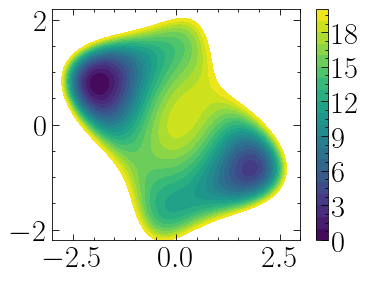

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from matplotlib import colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib import cm, ticker
from matplotlib.colors import LinearSegmentedColormap


if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
boldfont = {'fontname':'Helvetica', 'fontweight':'bold'}

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

grid = np.linspace(-3, 3, 200); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
cutoff_inve19 = np.where(inve_pot <= 19, 1, 0)
plt.figure(figsize=(4,3)); plt.contourf(X,Y,inve_pot, levels=np.arange(0, 21, 1), cmap='viridis'); plt.colorbar(); plt.ylim(-2.2, 2.2); plt.show()

# plt.rcParams['xtick.minor.visible'] = False
# plt.rcParams['ytick.minor.visible'] = False

# plt.rcParams['xtick.minor.visible'] = True
# plt.rcParams['ytick.minor.visible'] = True

In [2]:
def MFI_2D(HILLS="HILLS", position_x="position_x", position_y="position_y", bw_x=0.1, bw_y=0.1, kT=1,
			min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), nbins=np.array((200, 200)),
			error_pace=-1, base_terms = 0, window_corners=[], WellTempered=1, nhills=-1, periodic_x=0, periodic_y=0, 
			Ftot_den_limit = 1E-10, FES_cutoff = -1, Ftot_den_cutoff = 0.1, non_exploration_pentaly=-1, use_weighted_st_dev = True,
			hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=0, hp_kappa_y=0,
			lw_centre_x=0.0, lw_centre_y=0.0, lw_kappa_x=0, lw_kappa_y=0,
			uw_centre_x=0.0, uw_centre_y=0.0, uw_kappa_x=0, uw_kappa_y=0, ref_fes = np.zeros((200,200)), F_static_x = np.zeros((1,1)), F_static_y = np.zeros((1,1))):
	"""Compute a time-independent estimate of the Mean Thermodynamic Force, i.e. the free energy gradient in 2D CV spaces.

	Args:
		HILLS (str): HILLS array. Defaults to "HILLS".
		position_x (str): CV1 array. Defaults to "position_x".
		position_y (str): CV2 array. Defaults to "position_y".
		bw (int, optional): Scalar, bandwidth for the construction of the KDE estimate of the biased probability density. Defaults to 1.
		kT (int, optional): Scalar, kT. Defaults to 1.
		min_grid (array, optional): Lower bound of the force domain. Defaults to np.array((-np.pi, -np.pi)).
		max_grid (array, optional): Upper bound of the force domain. Defaults to np.array((np.pi, np.pi)).
		nbins (array, optional): number of bins in CV2,CV1. First enrty is the number of bins in CV2 and the second entry is the number of bins in CV1! Defaults to np.array((200,200)). 
		error_pace (int, optional): Pace for the calculation of the on-the-fly measure of global convergence. Defaults to 1, change it to a higher value if FES_cutoff>0 is used. 
		base_terms (int or list, optional): When set to 0, inactive. When activated, "on the fly" variance is calculated as a patch to base (previous) simulation. To activate, put force terms of base simulation ([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]). Defaults to 0.
		window_corners (list, optional): When set to [], inactive. When activated, error is ALSO calculated for mean force in the window. To activate, put the min and max values of the window ([min_x, max_x, min_y, max_y]). Defaults to [].
		WellTempered (binary, optional): Is the simulation well tempered? . Defaults to 1.
		nhills (int, optional): Number of HILLS to analyse, -1 for the entire HILLS array. Defaults to -1, i.e. the entire dataset.
		periodic (int, optional): Is the CV space periodic? 1 for yes. Defaults to 0.
		Ftot_den_limit (float, optional): Truncation of the probability density for numerical reasons, to avaiod devisions by zero (or suare root of negative numbers). If the probability density (Ftot_den) of some CV region is lover than the Ftot_den_limit, it will be set to zero. Default is set to 1E-10.
		FES_cutoff (float, optional): Cutoff applied to error calculation for FES values over the FES_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0. When FES_cutoff <= 0, no cufoff is applied. Use with care, computing the fes in the loop renders the calculation slow.
		Ftot_den_cutoff (float, optional): Cutoff applied to error calculation for probability density (Ftot_den) values below the Ftot_den_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0.1. When Ftot_den_cutoff <= 0, no cufoff is applied. 
		non_exploration_penalty (float, optional): Turns zero-value error to the non_exploration_penalty value. This should be used in combination with the cutoff. If some part of CV space hasn't been explored, or has a FES value that is irrelevanlty high, the cutoff will set the error of that region to zero. If the non_exploration_penalty is larger than zero, the error of that region will take the value of the non_exploration_penalty instead of zero. Default is set to 0.
		hp_centre_x (float, optional): CV1-position of harmonic potential. Defaults to 0.0.
		hp_centre_y (float, optional): CV2-position of harmonic potential. Defaults to 0.0.
		hp_kappa_x (int, optional): CV1-force_constant of harmonic potential. Defaults to 0.
		hp_kappa_y (int, optional): CV2-force_constant of harmonic potential. Defaults to 0.
		lw_centre_x (float, optional): CV1-position of lower wall potential. Defaults to 0.0.
		lw_centre_y (float, optional): CV2-position of lower wall potential. Defaults to 0.0.
		lw_kappa_x (int, optional): CV1-force_constant of lower wall potential. Defaults to 0.
		lw_kappa_y (int, optional): CV2-force_constant of lower wall potential. Defaults to 0.
		uw_centre_x (float, optional): CV1-position of upper wall potential. Defaults to 0.0.
		uw_centre_y (float, optional): CV2-position of upper wall potential. Defaults to 0.0.
		uw_kappa_x (int, optional): CV1-force_constant of upper wall potential. Defaults to 0.
		uw_kappa_y (int, optional): CV2-force_constant of upper wall potential. Defaults to 0.

	Returns:
		X: array of size (nbins[0], nbins[1]) - CV1 grid positions
		Y: array of size (nbins[0], nbins[1]) - CV2 grid positions
		Ftot_den: array of size (nbins[0], nbins[1]) - Cumulative biased probability density, equivalent to an unbiased histogram of samples in CV space.
		Ftot_x:  array of size (nbins[0], nbins[1]) - CV1 component of the Mean Force.
		Ftot_y:  array of size (nbins[0], nbins[1]) - CV2 component of the Mean Force.
		ofe:  array of size (nbins[0], nbins[1]) - on the fly estimate of the local convergence
		ofe_history: array of size (1, total_number_of_hills) - running estimate of the global convergence of the mean force.
		(option with window corner activated: ofe_history_window: array of size (1, total_number_of_hills) - running estimate of the "window" convergence of the mean force.)
		ofe_history_time: array of size (1, total_number_of_hills) - time array of ofe_history
		Ftot_den2: array of size (nbins[0], nbins[1]) - Cumulative squared biased probability density
		ofv_x: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV1 "on the fly variance" ( sum of: pb_t * dfds_x ** 2)
		ofv_y: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV2 "on the fly variance" ( sum of: pb_t * dfds_y ** 2)
	"""

	gridx = np.linspace(min_grid[0], max_grid[0], nbins[1])
	gridy = np.linspace(min_grid[1], max_grid[1], nbins[0])
	grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[1]-1), (max_grid[1] - min_grid[1]) / (nbins[0]-1)))
	X, Y = np.meshgrid(gridx, gridy)
	stride = int(len(position_x) / len(HILLS))
	bw_xy = np.sqrt(bw_x * bw_y)
	bw_xy2  = bw_xy ** 2
	bw_x2 = bw_x ** 2
	bw_y2 = bw_y ** 2
	const = (1 / (bw_xy * np.sqrt(2 * np.pi) * stride))

	# Optional - analyse only nhills, if nhills is set
	if nhills > 0: total_number_of_hills = nhills
	else: total_number_of_hills = len(HILLS)
	if error_pace == -1: error_pace = int(total_number_of_hills / 100)
	elif error_pace == -2: error_pace = int(total_number_of_hills / 10)
	elif error_pace < 0: error_pace = total_number_of_hills
	if FES_cutoff > 0: FES_cutoff = [FES_cutoff, min_grid, max_grid, np.array((periodic_x, periodic_y))]
 
	# Initialize force terms
	Fbias_x = np.zeros(nbins)
	Fbias_y = np.zeros(nbins)
	Ftot_num_x = np.zeros(nbins)
	Ftot_num_y = np.zeros(nbins)
	Ftot_den = np.zeros(nbins)
	Ftot_den2 = np.zeros(nbins)
	ofv_num_x = np.zeros(nbins)
	ofv_num_y = np.zeros(nbins)
	cutoff = np.ones(nbins)
	volume_history = []
	ofe_history = []
	aad_history = []
	time_history = []
	if len(window_corners) == 4: ofe_history_window = []

	#Calculate static force
	if np.shape(F_static_x) != (nbins[1], nbins[0]): F_static_x = np.zeros(nbins[::-1])
	if np.shape(F_static_y) != (nbins[1], nbins[0]): F_static_y = np.zeros(nbins[::-1])
	if hp_kappa_x > 0 or hp_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_hp_force(hp_centre_x, hp_centre_y, hp_kappa_x, hp_kappa_y, X , Y, min_grid, max_grid, grid_space, periodic = np.array((periodic_x, periodic_y)))
		F_static_x += Force_x
		F_static_y += Force_y
	if lw_kappa_x > 0 or lw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_lw_force(lw_centre_x, lw_centre_y, lw_kappa_x, lw_kappa_y, X , Y, periodic = np.array((periodic_x, periodic_y)))
		F_static_x += Force_x
		F_static_y += Force_y
	if uw_kappa_x > 0 or uw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_uw_force(uw_centre_x, uw_centre_y, uw_kappa_x, uw_kappa_y, X , Y, periodic = np.array((periodic_x, periodic_y)))
		F_static_x += Force_x
		F_static_y += Force_y

	# Definition Gamma Factor, allows to switch between WT and regular MetaD
	if WellTempered < 1: Gamma_Factor = 1
	else: Gamma_Factor = (HILLS[0, 6] - 1) / (HILLS[0, 6])
		
	for i in range(total_number_of_hills):
		
		# Build metadynamics potential
		s_x = HILLS[i, 1]  # centre x-position of Gaussian
		s_y = HILLS[i, 2]  # centre y-position of Gaussian
		sigma_meta2_x = HILLS[i, 3] ** 2  # width of Gaussian
		sigma_meta2_y = HILLS[i, 4] ** 2  # width of Gaussian
		height_meta = HILLS[i, 5] * Gamma_Factor  # Height of Gaussian

		periodic_images = MFI.find_periodic_point(s_x, s_y, min_grid, max_grid, periodic = np.array((periodic_x, periodic_y)))
		for j in range(len(periodic_images)):
			kernelmeta_x = np.exp( - np.square(gridx - periodic_images[j][0]) / (2 * sigma_meta2_x)) * height_meta
			kernelmeta_y = np.exp( - np.square(gridy - periodic_images[j][1]) / (2 * sigma_meta2_y))
			Fbias_x += np.outer(kernelmeta_y, np.multiply(kernelmeta_x, (gridx - periodic_images[j][0])) / sigma_meta2_x )
			Fbias_y += np.outer(np.multiply(kernelmeta_y, (gridy - periodic_images[j][1])) / sigma_meta2_y, kernelmeta_x )

		# Estimate the biased proabability density p_t ^ b(s)
		pb_t = np.zeros(nbins)
		Fpbt_x = np.zeros(nbins)
		Fpbt_y = np.zeros(nbins)

		data_x = position_x[i * stride: (i + 1) * stride]
		data_y = position_y[i * stride: (i + 1) * stride]

		for j in range(stride):
			periodic_images = MFI.find_periodic_point(data_x[j], data_y[j], min_grid, max_grid, periodic = np.array((periodic_x, periodic_y)))
			for k in range(len(periodic_images)):
				kernel_x = np.exp( - np.square(gridx - periodic_images[k][0]) / (2 * bw_x2)) * const #add constant here for less computations
				kernel_y = np.exp( - np.square(gridy - periodic_images[k][1]) / (2 * bw_y2))
				kernel = np.outer(kernel_y, kernel_x)
				kernel_x *= kT / bw_xy2 #add constant here for less computations

				pb_t += kernel
				Fpbt_x += np.outer(kernel_y, np.multiply(kernel_x, (gridx - periodic_images[k][0])) )
				Fpbt_y += np.outer(np.multiply(kernel_y, (gridy - periodic_images[k][1])) , kernel_x )

		# Calculate total probability density
		pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
		Ftot_den += pb_t
		
		# Calculate x-component of Force
		dfds_x = np.divide(Fpbt_x, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t > 0) + Fbias_x - F_static_x
		Ftot_num_x += np.multiply(pb_t, dfds_x)
		
		# Calculate y-component of Force
		dfds_y = np.divide(Fpbt_y, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t > 0) + Fbias_y - F_static_y
		Ftot_num_y += np.multiply(pb_t, dfds_y)

		# calculate on the fly error components
		Ftot_den2 += np.square(pb_t)
		ofv_num_x += np.multiply(pb_t, np.square(dfds_x))
		ofv_num_y += np.multiply(pb_t, np.square(dfds_y))

		if (i + 1) % int(error_pace) == 0 or (i+1) == total_number_of_hills:
			#calculate forces
			Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den > 0)
			Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den > 0)

			# calculate ofe (standard error)
			if base_terms == 0:
				[ofv, ofe] = MFI.mean_force_variance(Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y, use_weighted_st_dev=use_weighted_st_dev)
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot] = [np.array(Ftot_den), np.array(Ftot_x), np.array(Ftot_y)]
			elif len(base_terms) == 6:
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot, ofv, ofe] = MFI.patch_to_base_variance(base_terms, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y], use_weighted_st_dev=use_weighted_st_dev)

			# If specified, apply cutoff to error and/or non_exploration_pentaly
			if Ftot_den_cutoff > 0 or hasattr(FES_cutoff, "__len__"): cutoff = MFI.get_cutoff(Ftot_den_tot, Ftot_den_cutoff=Ftot_den_cutoff, FX=Ftot_x_tot, FY=Ftot_y_tot, FES_cutoff=FES_cutoff)			
			if non_exploration_pentaly > 0: ofe = np.where(cutoff > 0.5, ofe, non_exploration_pentaly)
			else: ofe *= cutoff
   
			# ofe = np.where(ref_fes < 19, ofe, 0)

			#Calculate averaged global error
			absolute_explored_volume = np.count_nonzero(cutoff)
			# if i ==0: print("ofe is cut where inve_Pot < 19")
			volume_history.append( absolute_explored_volume/(nbins[0]*nbins[1]))
			if non_exploration_pentaly <= 0: ofe_history.append( np.sum(ofe) / absolute_explored_volume)
			else: ofe_history.append( np.sum(ofe) / (nbins[0]*nbins[1]))
			time_history.append(HILLS[i,0] + HILLS[2,0] - HILLS[1,0])
			if len(window_corners) == 4:
				ofe_cut_window = MFI.reduce_to_window(ofe, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3]) 
				ofe_history_window.append(np.sum(ofe_cut_window) / (np.count_nonzero(ofe_cut_window)))
    
    
			#Find Absolute devaition
			[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_tot, Ftot_y_tot, min_grid=min_grid, max_grid=max_grid)
			AD = abs(ref_fes - FES)
			ADc = AD * cutoff
			# ADc = np.where(ref_fes < 19, ADc, 0)
			AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
			AADc = np.sum(ADc)/(np.count_nonzero(ADc))
			aad_history.append([AAD,AADc])

			#print progress
			MFI.print_progress(i+1,total_number_of_hills,variable_name='Average Mean Force Error',variable=round(ofe_history[-1],3))        
			# if len(window_corners) == 4: print("    ||    Error in window", ofe_history_window[-1])		

			
	if len(window_corners) == 4: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
  
	else: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y]



NameError: name 'np' is not defined

In [3]:
# temp: why plumed doesn't work from jupyter notebook

os.chdir("/home/ucecabj/Desktop/pyMFI_git/DATA_examples/Invernizzi_2D_potential_more_data")
# Run simulation
# run_plumed.run_2D_Invernizzi(simulation_steps=250000, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=-1.2, initial_position_y=-1.2,
#                 hp_centre_x=-1.2, hp_centre_y=-1.2, hp_kappa_x=20, hp_kappa_y=20, file_extension="HP_"+str(0))

# sys.path.append("/usr/ulocal/")

# os.environ

# "/usr/ulocal/bin/plumed"
# os.environ['PATH'] += os.pathsep + '/usr/ulocal/bin/'

# os.environ['PATH'] += os.pathsep + "/usr/ulocal/include/"
# os.environ['PATH'] += os.pathsep + "/usr/ulocal/lib/"
# os.environ['PATH'] += os.pathsep + "/usr/ulocal/lib/pkgconfig/"
# os.environ['PATH'] += os.pathsep + "/usr/ulocal/lib/libplumedKernel.so"


# import os
# os.system("source ~/.bashrc")

!plumed -h

import os
os.environ['PATH']

/bin/bash: plumed: command not found


'/usr/ulocal/anaconda3/bin:/usr/ulocal/anaconda3/condabin:/home/ucecabj/.local/bin:/usr/local/cuda-11.8/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin'

#### (1) - Running long simulations

In [4]:
#Run simulation 
# os.chdir(path_manustript + "Figure2")

# # Run simulation
# run_plumed.run_2D_Invernizzi(simulation_steps=10000000, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=1, initial_position_y=-1, file_extension="long")

In [3]:
os.chdir(path_manustript + "Figure2")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_long")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_long")

#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.05, bw_y = 0.05, kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), error_pace = 100, FES_cutoff=-1, nhills=10000, ref_fes=inve_pot, use_weighted_st_dev = False)

#integration on a non-periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

#Find Absolute devaition
AD = abs(inve_pot - FES) 
ADc = AD * cutoff
# ADc = np.where(inve_pot < 19, ADc, 0)
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("AAD =" ,round(AAD,2) , "   |    AAD_(where inve_pot<19kJ/mol) =", round(AADc,2))

[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1, volume_history_1] = [FES, Ftot_den, ofe, ADc, cutoff, time_history, ofe_history, aad_history, volume_history]

|**************************************************| 100% | Average Mean Force Error: 3.805AAD = 33.38    |    AAD_(where inve_pot<19kJ/mol) = 1.01


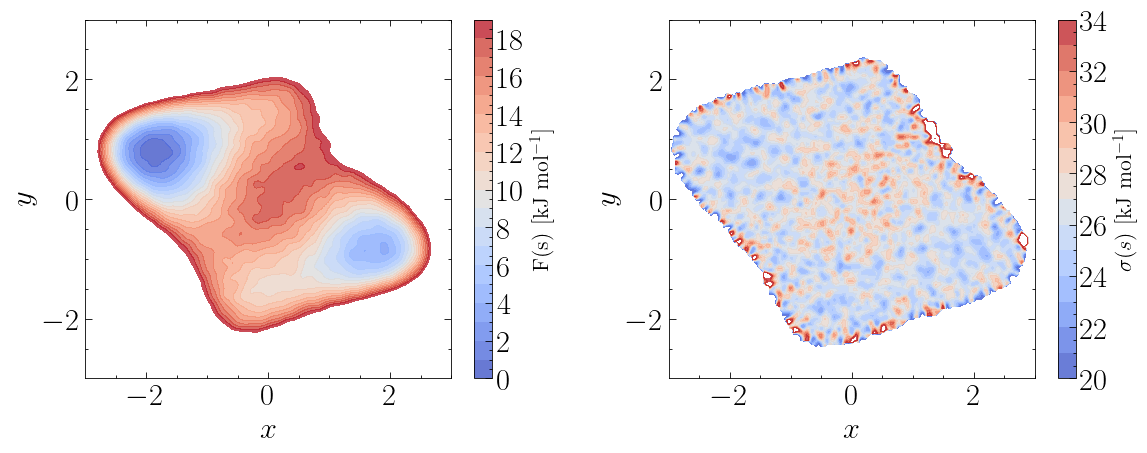

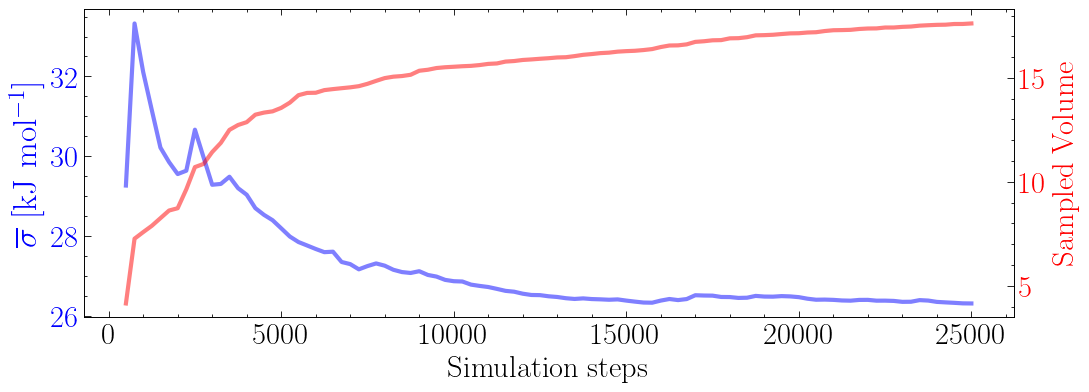

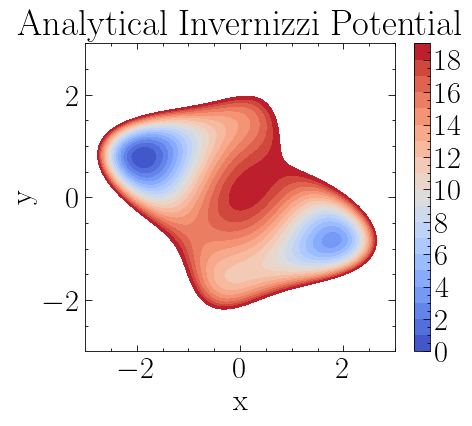

In [4]:
# Plot 1 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 20, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe*cutoff, levels=np.arange(20, 35, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$]",fontsize=16)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

plt.savefig('Figure2_A', dpi=600, bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(12, 4))

OFE_history_long=ofe_history[1:]
time_OFE_history_long=[time for time in time_history[1:]]

axs.plot( [time for time in time_history[1:]], (ofe_history[1:]),color='blue',alpha=0.5,linewidth=3);
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='blue')
axs.tick_params(axis ='y', labelcolor = 'blue')
axs.set_xlabel('Simulation steps')

ax2 = axs.twinx()
ax2.set_xlabel('Simulation steps')
ax2.set_ylabel('Sampled Volume',color='red')
ax2.tick_params(axis ='y', labelcolor = 'red')
ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:],np.power(6,2)),color='red',alpha=0.5,linewidth=3);

plt.savefig('Figure2B', dpi=600, bbox_inches='tight')


grid = np.linspace(-3, 3, 200); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)

plt.figure(figsize=(5,4)); 
plt.contourf(X, Y, inve_pot, levels=range(0, 20, 1), cmap='coolwarm')
plt.xlabel("x"); plt.ylabel("y"); 
plt.title("Analytical Invernizzi Potential"); 
plt.colorbar()
plt.show()


#### (2) - Running multiple short simulations

In [5]:
#Run simulation
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential")

# simulation_steps = 250000
#for simulation in np.arange(0,n_simulations): 
    #print('Simulation: '+str(simulation), end="  |   ")
    #file_extension="" + str(int(simulation))
    
    #RUN short sim from random location
    #ipos=1.3*(2 * np.random.rand(2) - 1)
    #run_plumed.run_2D_Invernizzi(simulation_steps=simulation_steps, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=ipos[0], initial_position_y=ipos[1], file_extension=file_extension)
    

In [4]:
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")
pbt_bandwidth = 0.05
n_simulations = 20

master = []
master_patch = [[np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200))]]
ofe_history_patch = []
aad_history_patch = []
volume_history_patch = []
ofe_history_patch_time = []

for simulation in np.arange(0,n_simulations): 
    
    file_extension="inve_" + str(int(simulation))
    # print('\nSimulation: ' + str(simulation) + ' (ext=' + str(file_extension) + ')' )

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + file_extension)
    [position_x, position_y] = MFI.load_position_2D(position_name="position" + file_extension)

    #COMPUTE Mean force and weight of the simulation
    results = MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = pbt_bandwidth, bw_y = pbt_bandwidth, kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), error_pace=100, base_terms = master_patch[-1], ref_fes=inve_pot, use_weighted_st_dev = False)
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save error history
    ofe_history_patch += ofe_history
    aad_history_patch += aad_history
    volume_history_patch += volume_history
    if len(ofe_history_patch_time) > 0: ofe_history_patch_time += [element+ofe_history_patch_time[-1] for element in time_history]
    else: ofe_history_patch_time += time_history
    

#integration on a non-periodic! domain
[Xp, Yp, FES_patch] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))
cutoff_2 = MFI.get_cutoff(Ftot_den=master_patch[-1][0])

AD = abs(inve_pot - FES_patch) 
ADc = AD * cutoff_2
# ADc = np.where(inve_pot < 19, ADc, 0)
AAD = np.sum(AD)/(FES_patch.shape[0]*FES_patch.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("AAD:", AAD)
print("AAD cut:", AADc)

[FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2, volume_history_2] = [FES_patch, master_patch[-1][0], ofe, ADc, cutoff_2, ofe_history_patch_time, ofe_history_patch, aad_history_patch, volume_history_patch]

|**************************************************| 100% | Average Mean Force Error: 10.197AAD: 38.68376651497178
AAD cut: 2.2534476383951407


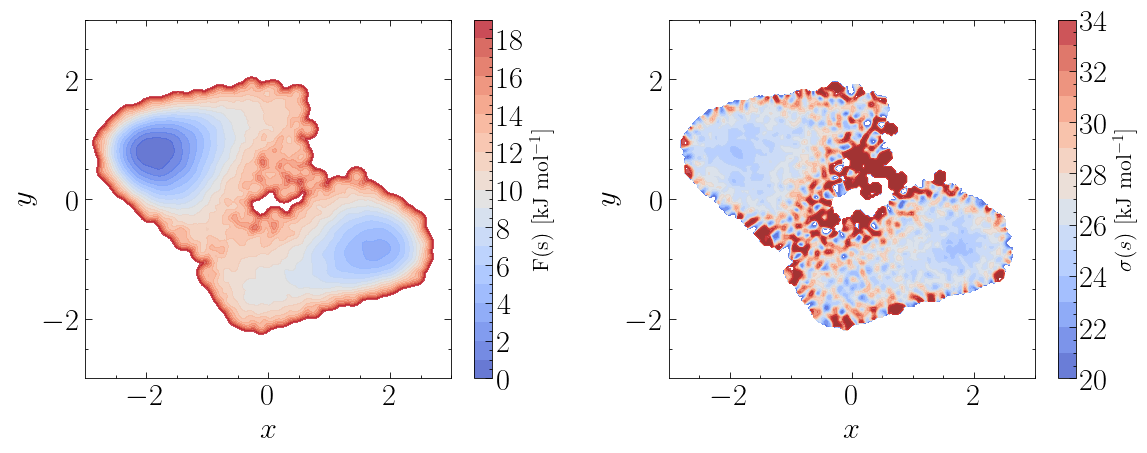

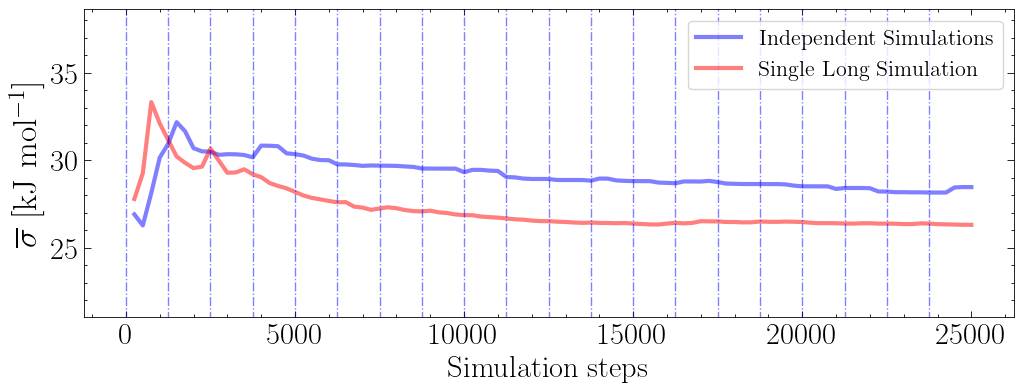

In [6]:
# plot 2
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")

#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i] for i in range(n_simulations)]

# Plot Results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cp = axs[0].contourf(Xp, Yp, FES_patch, levels=np.arange(0, 20, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe_patch*cutoff_2, levels=[35,200], cmap=colors.ListedColormap(['darkred']), antialiased=False, alpha=0.8);
cp = axs[1].contourf(X, Y, ofe_patch*cutoff_2, levels=np.arange(20, 35, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$]",fontsize=16)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

plt.savefig('Figure2_C', dpi=600, bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in ofe_history_patch_time], (ofe_history_patch),color='blue',alpha=0.5,linewidth=3,label="Independent Simulations");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')
axs.tick_params(axis ='y', labelcolor = 'black')

axs.plot( time_history_1, ofe_history_1 ,color='red',alpha=0.5,linewidth=3,label="Single Long Simulation");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')

axs.set_xlabel('Simulation steps')

for i in np.arange(0,n_simulations):
    axs.plot([i*1250,i*1250],[20,50],'-.',color='blue',linewidth=1,alpha=0.5)

axs.set_ylim([min(ofe_history_patch)*0.8,max(ofe_history_patch)*1.2])

axs.legend(fontsize=16)

plt.savefig('Figure2_D', dpi=600, bbox_inches='tight')

#ax2 = axs.twinx()
#ax2.set_xlabel('Simulation steps')
#ax2.set_ylabel('Sampled Volume',color='red')
#ax2.tick_params(axis ='y', labelcolor = 'red')
#ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:],np.power(6/200,2)),color='red',alpha=0.5,linewidth=3);


### NEW : instead of patching 20 normal simulations, only take 10 MetaD simulations and 10 MetaD+HP simulations, focusing on the unexplored region in the centre

In [13]:
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")
plot_on = "off"

# Only take the results from the first 10 simulations and remove the last 3
n_old_sim = 10
master_2 = master[:-(20-n_old_sim)]
master_patch_2 = master_patch[:-(20-n_old_sim)]
ofe_history_patch_2 = ofe_history_patch[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
ofe_history_patch_time_2 = ofe_history_patch_time[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
aad_history_patch_2 = aad_history_patch[:-int((20-n_old_sim)*len(aad_history_patch)/len(master))]
volume_history_patch_2 = volume_history_patch[:-int((20-n_old_sim)*len(volume_history_patch)/len(master))]

if plot_on == "on": 
    plt.figure(figsize=(8,8))
    for i in range(20-n_old_sim): 
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_" + str(i))
        plt.plot(HILLS[:,1],HILLS[:,2], 'o', mfc='none')

#Add 10 MetaD simulations with static harmonic potentials
d = 0.20
hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  #AAD 1.19 k=35 d=0.2
kappa = 35

pbt_bandwidth = 0.05
for simulation in [0,1,2,3,4,5,9,8,7,6]:   

    # # Run simulation
    # print("\nSimulation: ", simulation)          
    # run_plumed.run_2D_Invernizzi(simulation_steps=250000, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=hp_centre[simulation][0], initial_position_y=hp_centre[simulation][1],
    #             hp_centre_x=hp_centre[simulation][0], hp_centre_y=hp_centre[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa, file_extension="HP_"+str(simulation))
                                            
    #Read the HILLS and position file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(simulation))
    if plot_on == "on": plt.scatter(HILLS[:,1],HILLS[:,2], s=3)
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_HP_"+str(simulation))
        
    #MFI with metaD and HP
    results = MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, 
                            bw_x = pbt_bandwidth, bw_y = pbt_bandwidth, kT = 1, error_pace = 100, base_terms = master_patch_2[-1], nhills=-1, 
                            min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), #FES_cutoff = 20, 
                            hp_centre_x=hp_centre[simulation][0], hp_centre_y=hp_centre[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa, ref_fes=inve_pot, use_weighted_st_dev = False)
    
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results and patch with previous results
    master_2.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    master_patch_2.append(MFI.patch_2D(master_2))
    
    #save ofe history
    ofe_history_patch_2 += ofe_history
    aad_history_patch_2 += aad_history
    volume_history_patch_2 += volume_history
    ofe_history_patch_time_2 += [element+ofe_history_patch_time_2[-1] for element in time_history]
    

if plot_on == "on": plt.xlim(-3,3); plt.ylim(-3,3); plt.show()

#integration on a non-periodic! domain
[Xp, Yp, FES_patch_2] = MFI.FFT_intg_2D(master_patch_2[-1][2], master_patch_2[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))

cutoff_3 = MFI.get_cutoff(Ftot_den=master_patch_2[-1][0])

AD_3 = abs(inve_pot - FES_patch_2)
ADc_3 = AD_3 * cutoff_3
# ADc_3 = np.where(inve_pot < 19, ADc_3, 0) * cutoff_3
AAD_3 = np.sum(AD_3)/(FES_patch_2.shape[0]*FES_patch_2.shape[0])
AADc_3 = np.sum(ADc_3)/(np.count_nonzero(ADc_3))
print("\nAAD:", AAD_3)
print("AAD cut:", AADc_3)

[FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3, aad_history_3, volume_history_3] = [FES_patch_2, master_patch_2[-1][0], ofe, ADc_3, cutoff_3, ofe_history_patch_time_2, ofe_history_patch_2, aad_history_patch_2, volume_history_patch_2]

|**************************************************| 100% | Average Mean Force Error: 5.006
AAD: 39.39548627452068
AAD cut: 1.2901804194663518


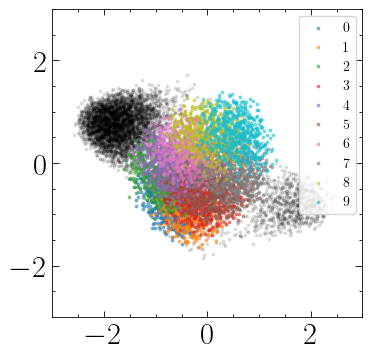

In [174]:
# plt hills 
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")

plt.figure(figsize=(4,4))
n_old_sim = 10
for i in range(20-n_old_sim): 
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_" + str(i))
    # plt.plot(HILLS[:,1],HILLS[:,2], 'o', mfc='none')
    plt.scatter(HILLS[:,1],HILLS[:,2], s=3, c="black", alpha=0.1)

# os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data/HP_forces_s0.1_k20")
# hp_centre = [[-1.2,-1.2],[-0.8, -0.8],[-0.6,-0.6],[-0.4,-0.4],[-0.2,-0.2],[0,0],[0.2,0.2],[0.4,0.4], [0.6, 0.6], [-1.0,-1.0]]

# for simulation in [0,1,2,9]:#np.arange(0,len(hp_centre)):   
for simulation in np.arange(0,len(hp_centre)):   
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(simulation))
    plt.scatter(HILLS[:,1],HILLS[:,2], s=3, label=str(simulation), alpha=0.5)
    
plt.xlim(-3,3); plt.ylim(-3,3); plt.legend(fontsize=10); plt.show()


NameError: name 'ofe_patch_2' is not defined

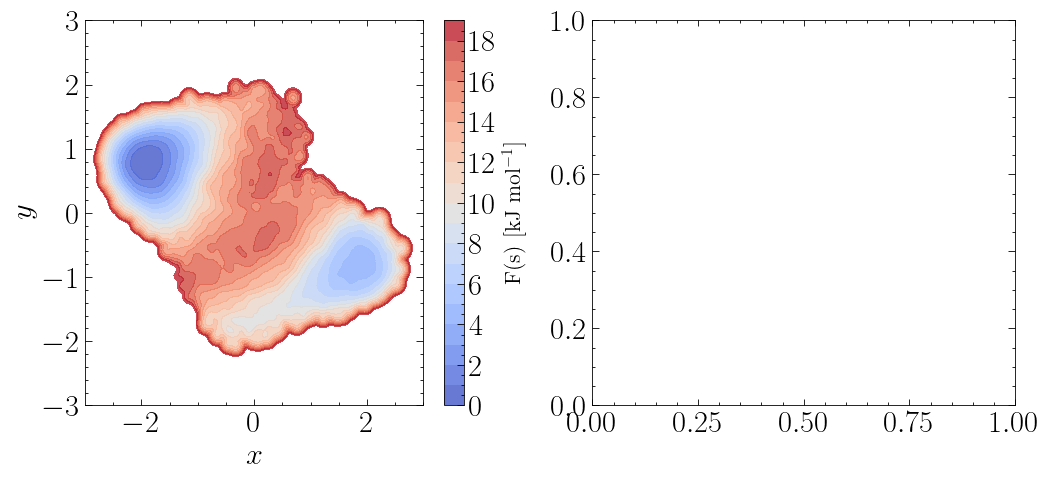

In [17]:
#plot 3
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")

#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i] for i in range(n_simulations)]

# Plot Results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cp = axs[0].contourf(Xp, Yp, FES_patch_2, levels=np.arange(0, 20, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe_patch_2*cutoff, levels=np.arange(20, 35, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$]",fontsize=16)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

plt.savefig('Figure2_C', dpi=600, bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in ofe_history_patch_time], (ofe_history_patch),color='blue',alpha=0.5,linewidth=3,label="Independent Simulations");
axs.plot( [time for time in ofe_history_patch_time_2], (ofe_history_patch_2),color='green',alpha=0.5,linewidth=3,label="Independent Sim. with HP");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')
axs.tick_params(axis ='y', labelcolor = 'black')

axs.plot( time_OFE_history_long, OFE_history_long ,color='red',alpha=0.5,linewidth=3,label="Single Long Simulation");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')

axs.set_xlabel('Simulation steps')

for i in np.arange(0,n_simulations):
    axs.plot([i*1250,i*1250],[20,50],'-.',color='blue',linewidth=1,alpha=0.5)

axs.set_ylim([min(ofe_history_patch_2)*0.8,max(ofe_history_patch_2)*1.2])

axs.legend(fontsize=16)

plt.savefig('Figure2_D', dpi=600, bbox_inches='tight')

#ax2 = axs.twinx()
#ax2.set_xlabel('Simulation steps')
#ax2.set_ylabel('Sampled Volume',color='red')
#ax2.tick_params(axis ='y', labelcolor = 'red')
#ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:],np.power(6/200,2)),color='red',alpha=0.5,linewidth=3);


### Plots

In [18]:
#load results for plotting
MFI.save_pkl([[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1], [FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2], [FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3, aad_history_3]], "/home/ucecabj/Desktop/pyMFI_git/DATA_examples/Invernizzi_2D_potential_more_data/plot_results.pkl")
# [FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1], [FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2], [FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3, aad_history_3] = MFI.load_pkl("/home/ucecabj/Desktop/pyMFI_git/DATA_examples/Invernizzi_2D_potential_more_data/plot_results.pkl")

In [6]:
# Grid plot (3x3)

plt_list = [FES_1, ofe_1*cutoff_1, MFI.zero_to_nan(AD_1*inve_cut_19), FES_2, ofe_2*cutoff_2, MFI.zero_to_nan(AD_2*inve_cut_19), FES_3, ofe_3*cutoff_3, MFI.zero_to_nan(AD_3*inve_cut_19)]
levels_list = [np.arange(0, 20, 1), np.arange(20, 36, 1), np.arange(0, 9, 1),np.arange(0, 20, 1), np.arange(20, 36, 1), np.arange(0, 9, 1),np.arange(0, 20, 1), np.arange(20, 36, 1), np.arange(0, 9, 1)]
cbar_loc = [0,0,0,0,0,0,  0, 10/30, 20/30]
cbar_label = ["","","","","","",  "FES [kJ mol$^{-1}$]", "$\overline{\sigma}$ [kJ mol$^{-1}$]", "AD [kJ mol$^{-1}$]"]
title_list = ["Free Energy Surface", "Mean Force Error",  "Absolute Deviation"]

fig = plt.figure(figsize=(15,20))

# Define the GridSpec with a spacer
gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 0.5, 1])

ax = []

# Create subplots for the first 3 rows with shared axes
for i in range(3):
    for j in range(3):
        if i == 0 and j == 0:
            ax.append(fig.add_subplot(gs[i, j]))
        else:
            ax.append(fig.add_subplot(gs[i, j], sharex=ax[0], sharey=ax[0]))

# Create the subplot for the fifth row (after the spacer)
ax.append(fig.add_subplot(gs[4, :]))

# Plot the sample data on each of the subplots
for axis in range(len(ax[:-4])):
    ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)
    if axis < 3: ax[axis].set_title(title_list[axis])
    
for axis in range(len(ax))[-4:-1]:
    contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)    
    axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], 1.3, 1/3, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
    fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
   
for i in range(len(hp_centre)): ax[7].scatter(hp_centre[i][0], hp_centre[i][1], c="r", alpha=0.3, s=200)
 

ax[-1].plot( time_history_1, ofe_history_1 ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-1].plot( time_history_2, ofe_history_2 ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-1].plot( time_history_3, ofe_history_3 ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")
ax[-1].set_xlabel("Simulation steps"); ax[-1].set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]")
ax[-1].legend();


for i in range(9):
    if i % 3 != 0: plt.setp(ax[i].get_yticklabels(), visible=False)
    if i < 6: plt.setp(ax[i].get_xticklabels(), visible=False)
    # ax[i].tick_params(left=False, right=False, bottom=False, top=False)
    
h_text = [0.865, 0.69, 0.52, 0.265]
w_text = [0.13, 0.39, 0.65]
fig.text(w_text[0], h_text[0], "a)"); fig.text(w_text[1], h_text[0], "b)"); fig.text(w_text[2], h_text[0], "c)")
fig.text(w_text[0], h_text[1], "d)"); fig.text(w_text[1], h_text[1], "e)"); fig.text(w_text[2], h_text[1], "f)")
fig.text(w_text[0], h_text[2], "g)"); fig.text(w_text[1], h_text[2], "h)"); fig.text(w_text[2], h_text[2], "i)")
fig.text(w_text[0], h_text[3], "j)")

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(path_manustript + 'Figure3/Figure3_inv_x10.png', dpi=600, bbox_inches='tight')

plt.show()

NameError: name 'inve_cut_19' is not defined

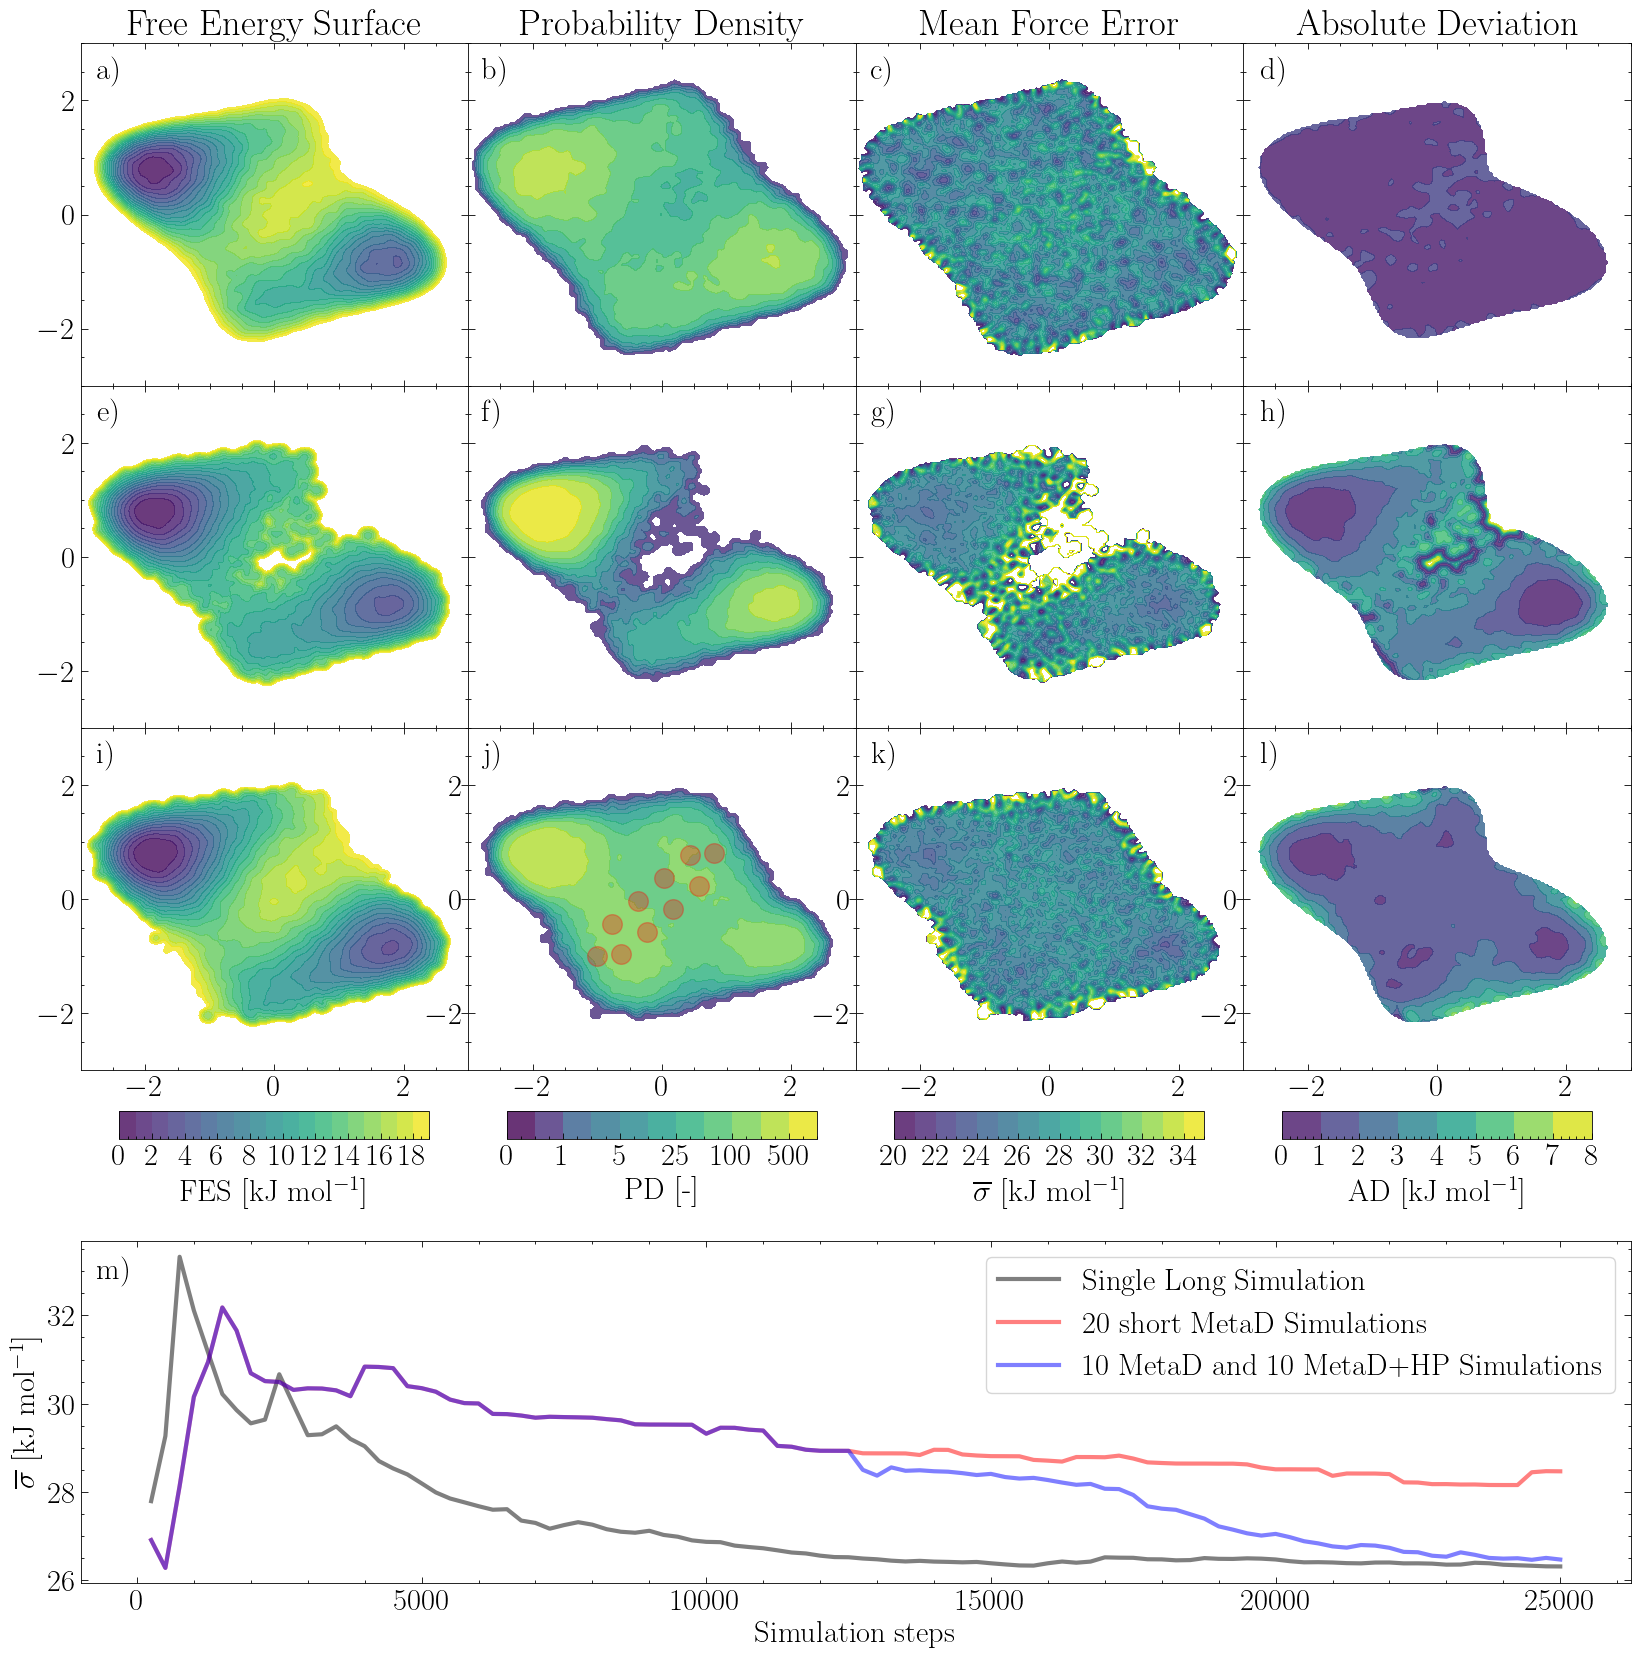

In [30]:
# Prid plot (3x4 with Ftot_den)

plt_list = [FES_1, np.where(Ftot_den_1>1E-1, Ftot_den_1,np.nan), ofe_1*cutoff_1, MFI.zero_to_nan(AD_1*inve_cut_19), FES_2, np.where(Ftot_den_2>1E-1, Ftot_den_2,np.nan), ofe_2*cutoff_2, MFI.zero_to_nan(AD_2*inve_cut_19), FES_3, np.where(Ftot_den_3>1E-1, Ftot_den_3,np.nan), ofe_3*cutoff_3, MFI.zero_to_nan(AD_3*inve_cut_19)]
levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(20, 36, 1), np.arange(0, 9, 1),np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(20, 36, 1), np.arange(0, 9, 1),np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(20, 36, 1), np.arange(0, 9, 1)]
PD_tick_loc = [0.01, 0.055, 0.1, 0.55, 1, 1.75, 2.5, 3.75, 5, 7.5, 10, 17.5, 25, 37.5, 50, 75, 100, 162.5, 225, 362.5, 500, 750, 1000]
cbar_loc = [0,0,0,0,0,0,0,0,  0, 1/4, 2/4, 3/4]
cbar_label = ["","","","","","","","",  "FES [kJ mol$^{-1}$]", "PD [-]", "$\overline{\sigma}$ [kJ mol$^{-1}$]", "AD [kJ mol$^{-1}$]"]
title_list = ["Free Energy Surface", "Probability Density", "Mean Force Error",  "Absolute Deviation"]
hp_centre = [[-1.0,-1.0],[-0.8+d, -0.8-d],[-0.6-d,-0.6+d],[-0.4+d,-0.4-d],[-0.2-d,-0.2+d],[0+d,0-d],[0.2-d,0.2+d],[0.4+d,0.4-d], [0.6-d, 0.6+d], [0.8, 0.8]]


fig = plt.figure(figsize=(20,20))

# Define the GridSpec with a spacer
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 0.5, 1])

ax = []

# Create subplots for the first 3 rows with shared axes
for i in range(3):
    for j in range(4):
        if i == 0 and j == 0:
            ax.append(fig.add_subplot(gs[i, j]))
        else:
            ax.append(fig.add_subplot(gs[i, j], sharex=ax[0], sharey=ax[0]))

# Create the subplot for the fifth row (after the spacer)
ax.append(fig.add_subplot(gs[4, :]))

# Plot the sample data on each of the subplots
for axis in range(len(ax[:-5])):
    if axis == 1 or axis == 5 : ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    else: ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)
    if axis < 4: ax[axis].set_title(title_list[axis])
    
for axis in range(len(ax))[-5:-1]:
    if axis == 9: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], 1.3, 1/4, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        cbar = fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
        cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(PD_tick_loc))
    else: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], 1.3, 1/4, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
    
for i in range(len(hp_centre)): ax[9].scatter(hp_centre[i][0], hp_centre[i][1], c="r", alpha=0.3, s=200)

ax[-1].plot( time_history_1, ofe_history_1 ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-1].plot( time_history_2, ofe_history_2 ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-1].plot( time_history_3, ofe_history_3 ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")
ax[-1].set_xlabel("Simulation steps"); ax[-1].set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]")
ax[-1].legend();


for i in range(9):
    if i % 4 != 0: plt.setp(ax[i].get_yticklabels(), visible=False)
    if i < 8: plt.setp(ax[i].get_xticklabels(), visible=False)
    # ax[i].tick_params(left=False, right=False, bottom=False, top=False)
    
h_text = [0.862, 0.691, 0.52, 0.262]
w_text = [0.133, 0.325, 0.52, 0.715]
fig.text(w_text[0], h_text[0], "a)"); fig.text(w_text[1], h_text[0], "b)"); fig.text(w_text[2], h_text[0], "c)"); fig.text(w_text[3], h_text[0], "d)")
fig.text(w_text[0], h_text[1], "e)"); fig.text(w_text[1], h_text[1], "f)"); fig.text(w_text[2], h_text[1], "g)"); fig.text(w_text[3], h_text[1], "h)")
fig.text(w_text[0], h_text[2], "i)"); fig.text(w_text[1], h_text[2], "j)"); fig.text(w_text[2], h_text[2], "k)"); fig.text(w_text[3], h_text[2], "l)")
fig.text(w_text[0], h_text[3], "m)")

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(path_manustript + 'Figure3/Figure3_inv_x13.png', dpi=600, bbox_inches='tight')

plt.show()

(0.0, 25000.0)

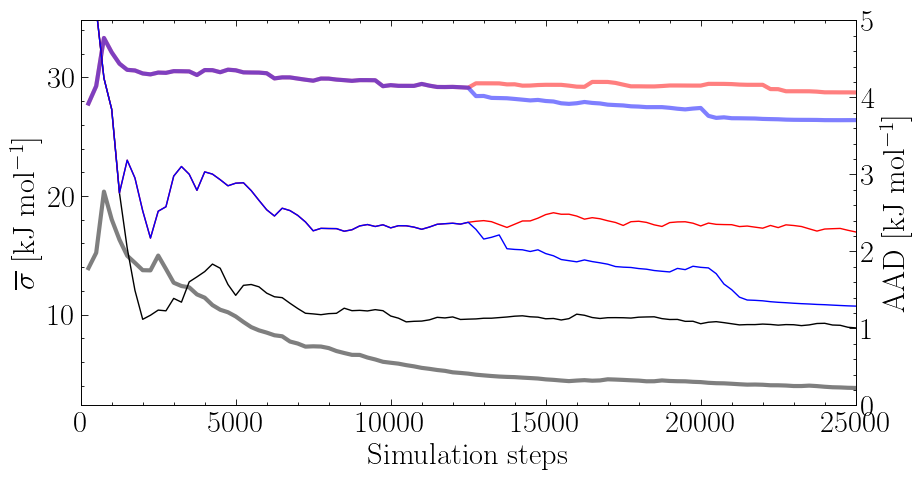

In [7]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot( time_history_1, ofe_history_1 ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax1.plot( time_history_2, ofe_history_2 ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax1.plot( time_history_3, ofe_history_3 ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

ax2.plot( time_history_1, np.asarray(aad_history_1)[:,1] ,color='black',linewidth=1,label="Single Long Simulation")
ax2.plot( time_history_2, np.asarray(aad_history_2)[:,1] ,color='red',linewidth=1,label="20 short MetaD Simulations")
ax2.plot( time_history_3, np.asarray(aad_history_3)[:,1] ,color='blue',linewidth=1,label="10 MetaD and 10 MetaD+HP Simulations")

ax1.set_xlabel("Simulation steps");
ax1.set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]")
ax2.set_ylabel("AAD [kJ mol$^{-1}$]")
ax2.set_ylim(0,5)
ax2.set_xlim(0,25000)



(0.0, 25000.0)

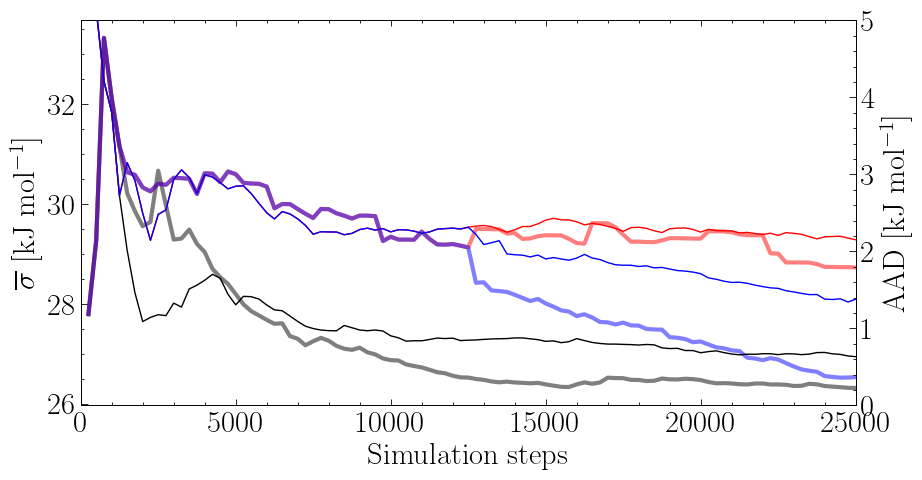

In [213]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot( time_history_1, ofe_history_1 ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax1.plot( time_history_2, ofe_history_2 ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax1.plot( time_history_3, ofe_history_3 ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

ax2.plot( time_history_1, np.asarray(aad_history_1)[:,1] ,color='black',linewidth=1,label="Single Long Simulation")
ax2.plot( time_history_2, np.asarray(aad_history_2)[:,1] ,color='red',linewidth=1,label="20 short MetaD Simulations")
ax2.plot( time_history_3, np.asarray(aad_history_3)[:,1] ,color='blue',linewidth=1,label="10 MetaD and 10 MetaD+HP Simulations")

ax1.set_xlabel("Simulation steps");
ax1.set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]")
ax2.set_ylabel("AAD [kJ mol$^{-1}$]")
ax2.set_ylim(0,5)
ax2.set_xlim(0,25000)

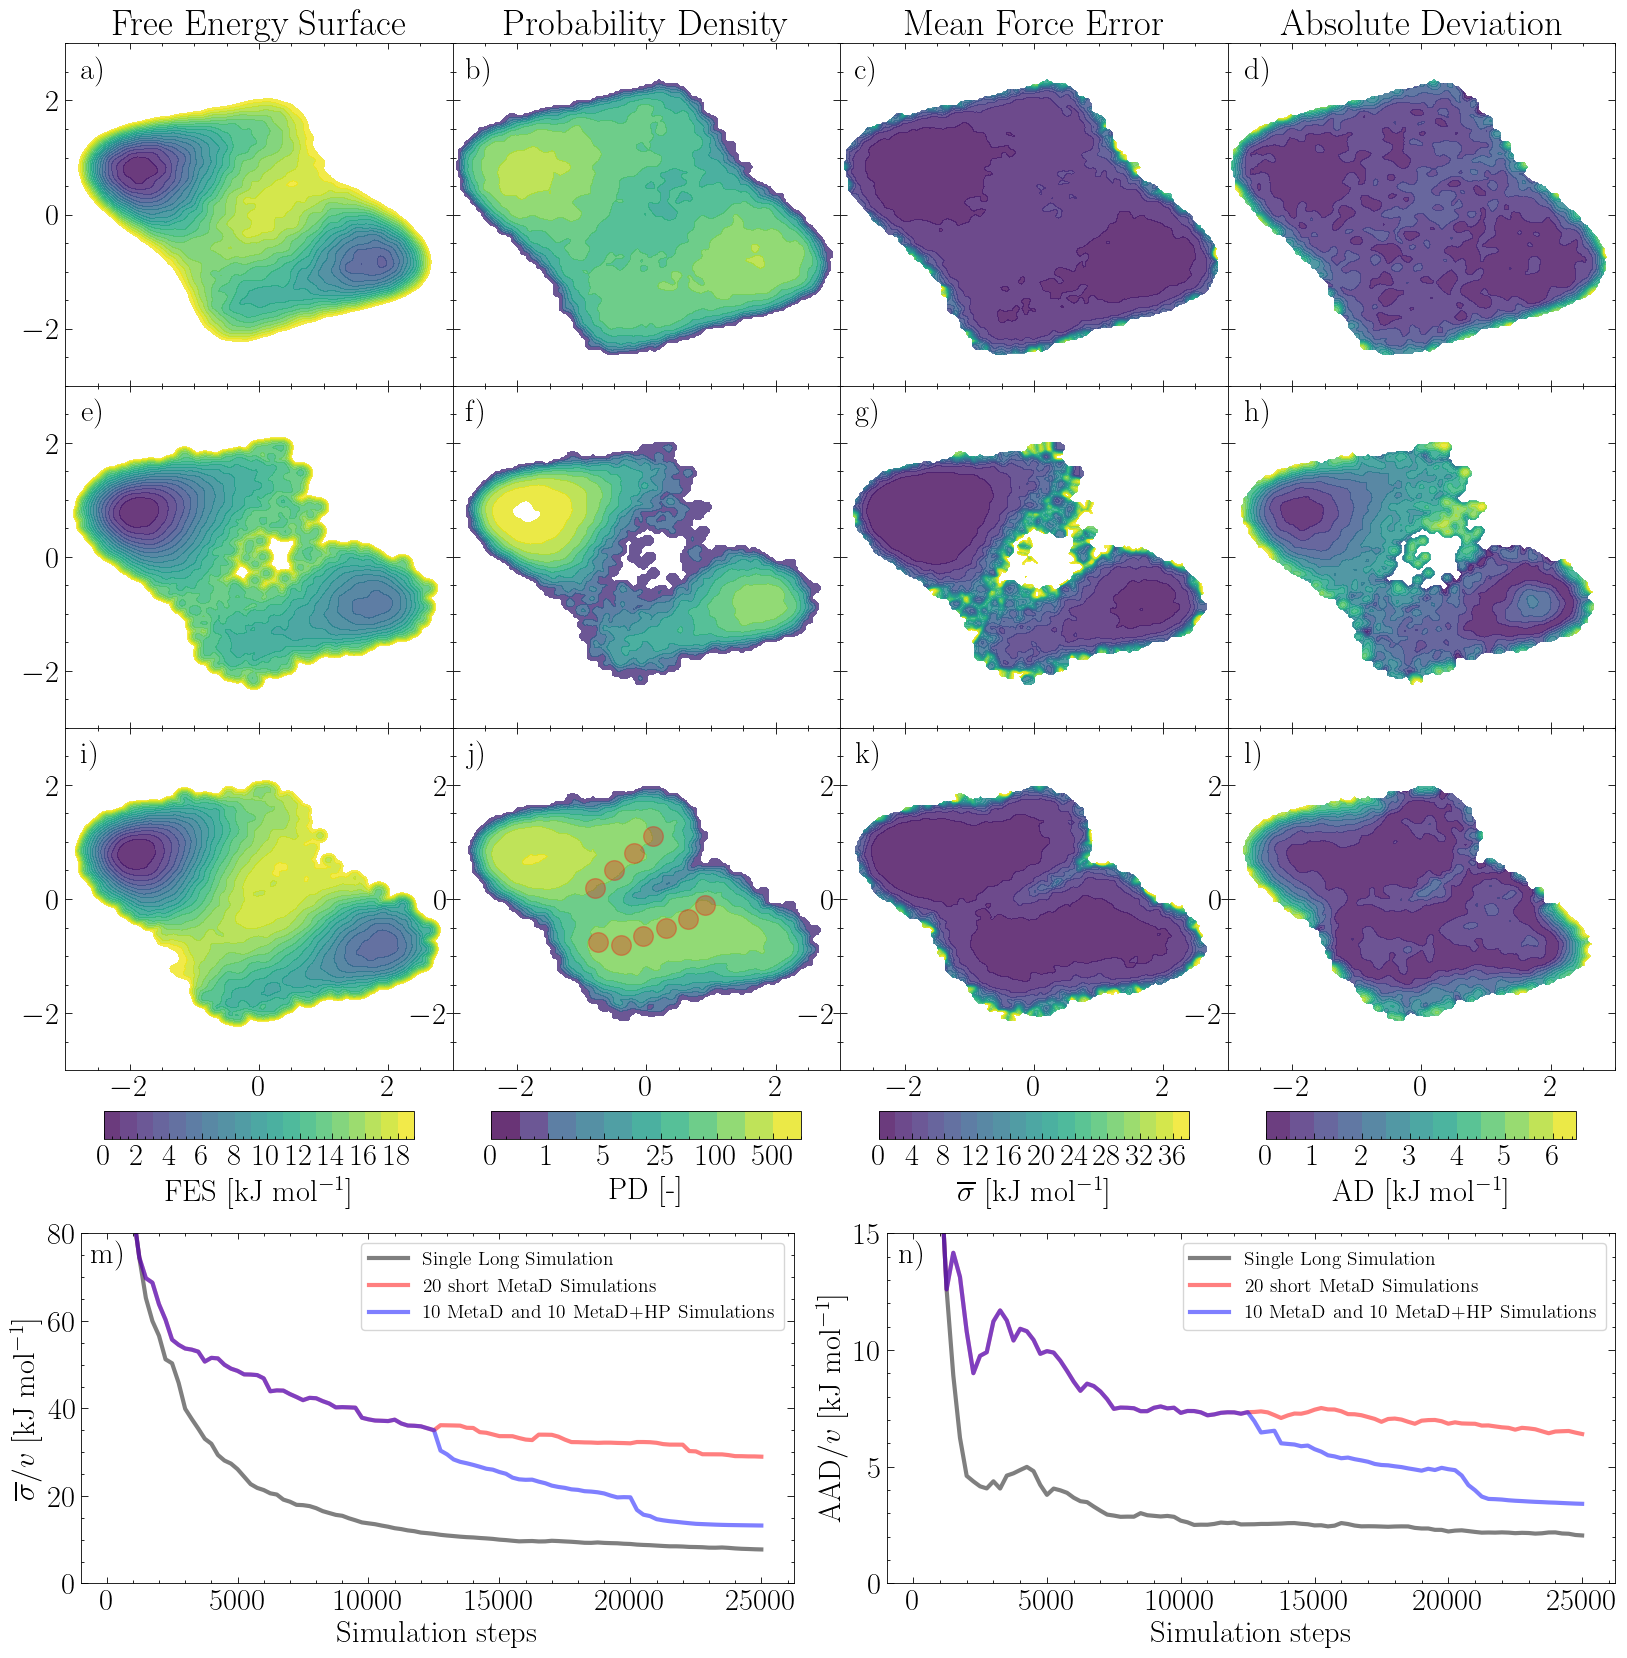

In [20]:
# NEW 021123 Prid plot (3x4 with Ftot_den + 1x2 error)
cutoff_inve19 = np.where(inve_pot < 19, 1, 0)
plt_list = [FES_1, np.where(Ftot_den_1>1E-1, Ftot_den_1,np.nan), MFI.zero_to_nan(ofe_1), MFI.zero_to_nan(AD_1), 
            FES_2, np.where(Ftot_den_2>1E-1, Ftot_den_2,np.nan), MFI.zero_to_nan(ofe_2), MFI.zero_to_nan(AD_2), 
            FES_3, np.where(Ftot_den_3>1E-1, Ftot_den_3,np.nan), MFI.zero_to_nan(ofe_3), MFI.zero_to_nan(AD_3)]
levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(0, 40, 2), np.arange(0, 7, 0.5)]
# levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], [20,21,22,23,24,25,26,27,28,29,30,40,50], np.arange(0, 7, 1)]
levels_list = levels_list + levels_list + levels_list
               
PD_tick_loc = [0.01, 0.055, 0.1, 0.55, 1, 1.75, 2.5, 3.75, 5, 7.5, 10, 17.5, 25, 37.5, 50, 75, 100, 162.5, 225, 362.5, 500, 750, 1000]
cbar_loc = [0,0,0,0,0,0,0,0,  -3, -2, -1, 0]
cbar_label = ["","","","","","","","",  "FES [kJ mol$^{-1}$]", "PD [-]", "$\overline{\sigma}$ [kJ mol$^{-1}$]", "AD [kJ mol$^{-1}$]"]
title_list = ["Free Energy Surface", "Probability Density", "Mean Force Error",  "Absolute Deviation"]

d=0.2
hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  #AAD 1.19 k=35 d=0.2

fig = plt.figure(figsize=(20,20))

# Define the GridSpec with a spacer
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 0.5, 1])

ax = []

# Create subplots for the first 3 rows with shared axes
for i in range(3):
    for j in range(4):
        if i == 0 and j == 0:
            ax.append(fig.add_subplot(gs[i, j]))
        else:
            ax.append(fig.add_subplot(gs[i, j], sharex=ax[0], sharey=ax[0]))

# Create the subplot for the fifth row (after the spacer)
# ax.append(fig.add_subplot(gs[4, :]))

# Plot the sample data on each of the subplots
for axis in range(len(ax[:-4])):
    if axis == 1 or axis == 5 : ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    else: ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)
    if axis < 4: ax[axis].set_title(title_list[axis])
    
for axis in range(len(ax))[-4:]:
    if axis == 9: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        cbar = fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
        cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(PD_tick_loc))
    else: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])

for j in [9]: 
    for i in range(len(hp_centre)): ax[j].scatter(hp_centre[i][0], hp_centre[i][1], c="r", alpha=0.3, s=200)

# ax = ax[:-1]
gs = gridspec.GridSpec(5, 100, height_ratios=[1, 1, 1, 0.4, 1])
ax.append(fig.add_subplot(gs[4, 1:47]))
ax.append(fig.add_subplot(gs[4, 53:]))

ax[-2].plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1),color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-2].plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-2].plot( time_history_3, np.asarray(ofe_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")
ax[-2].set_xlabel("Simulation steps"); ax[-2].set_ylabel("$\overline{\sigma}/ v$  [kJ mol$^{-1}$]")
ax[-2].set_ylim(0,80); ax[-2].legend(fontsize=14);

ax[-1].plot( time_history_1, np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-1].plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-1].plot( time_history_3, np.asarray(aad_history_3)[:,1] / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")
ax[-1].set_xlabel("Simulation steps"); ax[-1].set_ylabel("AAD$/v$ [kJ mol$^{-1}$]")
ax[-1].set_ylim(0,15); ax[-1].legend(fontsize=14);


for i in range(9):
    if i % 4 != 0: plt.setp(ax[i].get_yticklabels(), visible=False)
    if i < 8: plt.setp(ax[i].get_xticklabels(), visible=False)
    # ax[i].tick_params(left=False, right=False, bottom=False, top=False)
    
h_text = [0.862, 0.691, 0.52, 0.27]
w_text = [0.133, 0.325, 0.52, 0.715]
fig.text(w_text[0], h_text[0], "a)"); fig.text(w_text[1], h_text[0], "b)"); fig.text(w_text[2], h_text[0], "c)"); fig.text(w_text[3], h_text[0], "d)")
fig.text(w_text[0], h_text[1], "e)"); fig.text(w_text[1], h_text[1], "f)"); fig.text(w_text[2], h_text[1], "g)"); fig.text(w_text[3], h_text[1], "h)")
fig.text(w_text[0], h_text[2], "i)"); fig.text(w_text[1], h_text[2], "j)"); fig.text(w_text[2], h_text[2], "k)"); fig.text(w_text[3], h_text[2], "l)")
fig.text(w_text[0]+0.005, h_text[3], "m)")
fig.text(w_text[2]+0.022, h_text[3], "n)")

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(path_manustript + 'Figure3/Figure3_inv_x14.png', dpi=600, bbox_inches='tight')

plt.show()

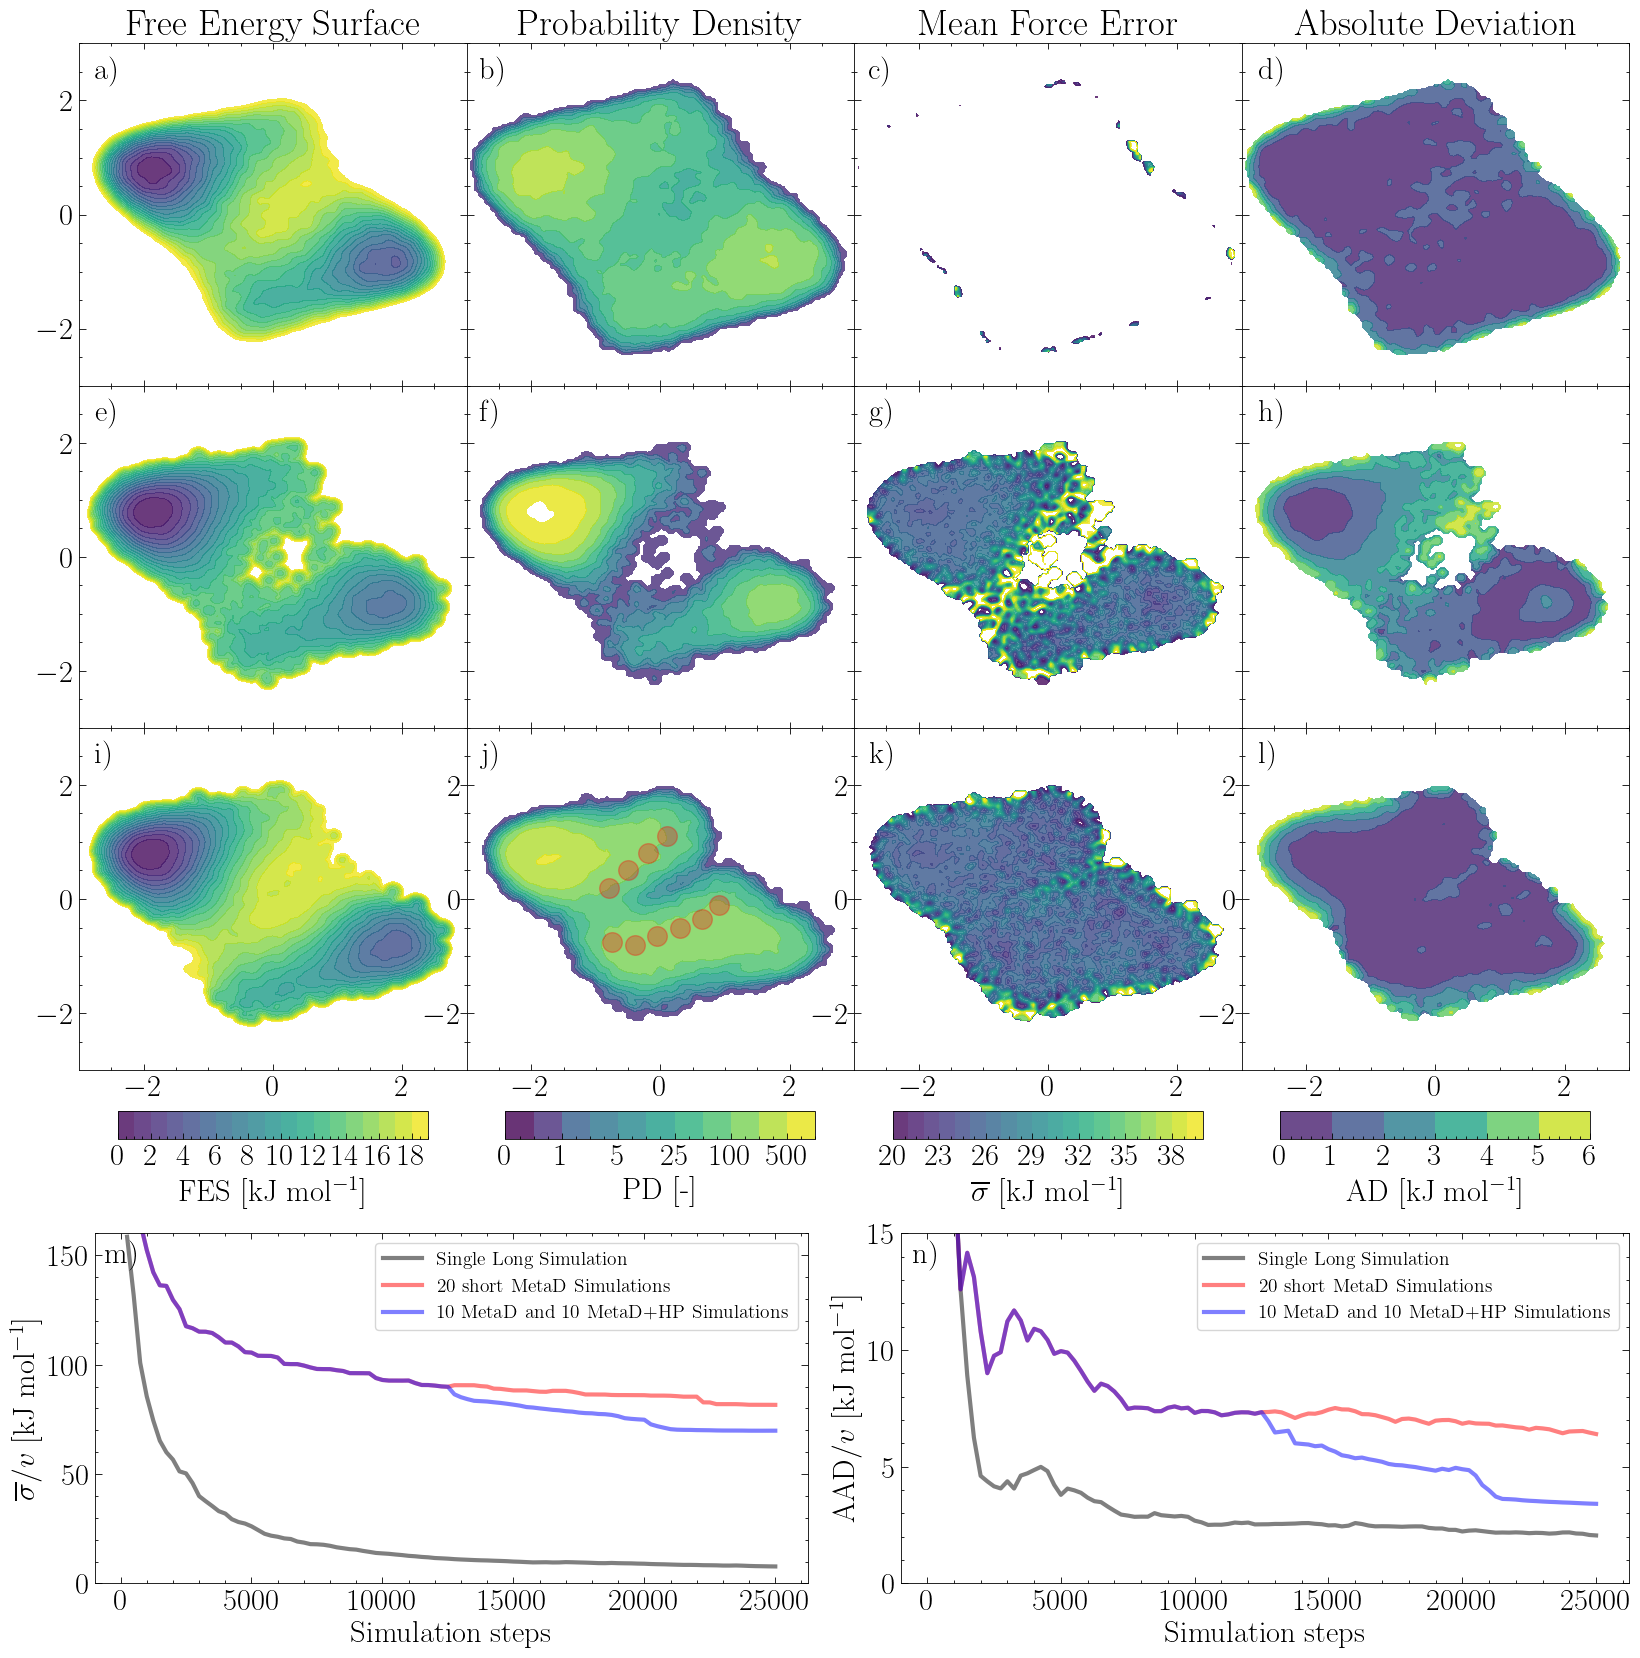

In [10]:
# Prid plot (3x4 with Ftot_den + 1x2 error)
cutoff_inve19 = np.where(inve_pot < 19, 1, 0)
plt_list = [FES_1, np.where(Ftot_den_1>1E-1, Ftot_den_1,np.nan), ofe_1, MFI.zero_to_nan(AD_1), 
            FES_2, np.where(Ftot_den_2>1E-1, Ftot_den_2,np.nan), ofe_2, MFI.zero_to_nan(AD_2), 
            FES_3, np.where(Ftot_den_3>1E-1, Ftot_den_3,np.nan), ofe_3, MFI.zero_to_nan(AD_3)]
levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(20, 41, 1), np.arange(0, 7, 1)]
# levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], [20,21,22,23,24,25,26,27,28,29,30,40,50], np.arange(0, 7, 1)]
levels_list = levels_list + levels_list + levels_list
               
PD_tick_loc = [0.01, 0.055, 0.1, 0.55, 1, 1.75, 2.5, 3.75, 5, 7.5, 10, 17.5, 25, 37.5, 50, 75, 100, 162.5, 225, 362.5, 500, 750, 1000]
cbar_loc = [0,0,0,0,0,0,0,0,  -3, -2, -1, 0]
cbar_label = ["","","","","","","","",  "FES [kJ mol$^{-1}$]", "PD [-]", "$\overline{\sigma}$ [kJ mol$^{-1}$]", "AD [kJ mol$^{-1}$]"]
title_list = ["Free Energy Surface", "Probability Density", "Mean Force Error",  "Absolute Deviation"]

d=0.2
# # hp_centre = [[-1.0,-1.0],[-0.8+d, -0.8-d],[-0.6-d,-0.6+d],[-0.4+d,-0.4-d],[-0.2-d,-0.2+d],[0+d,0-d],[0.2-d,0.2+d],[0.4+d,0.4-d], [0.6-d, 0.6+d], [0.8, 0.8]]
# # hp_centre = [[-0.75,-0.75],[-0.6+d, -0.6-d],[-0.5-d,-0.5+d],[-0.35+d,-0.35-d],[-0.25-d,-0.25+d],[-0.1+d,-0.1-d],[0-d,0+d],[0.15+d,0.15-d],[0.25-d,0.25+d], [0.5, 0.5]]
# # hp_centre = [[-0.75,-0.75],[-0.6+d, -0.6-d],[-0.55-d,-0.55+d],[-0.35+d,-0.35-d],[-0.3-d,-0.3+d],[-0.1+d,-0.1-d],[0-d,0+d],[0.2+d,0.2-d],[0.3-d,0.3+d], [0.6, 0.6]]  ##AAD 1.46 w k=35 d=0.2
# # hp_centre = [[-0.75,-0.75],[-0.6+d, -0.6-d],[-0.5-d,-0.5+d],[-0.35+d,-0.35-d],[-0.25-d,-0.25+d],[-0.1+d,-0.1-d],[0-d,0+d],[0.2+d,0.2-d],[0.3-d,0.3+d], [0.5, 0.5]]  
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+d,-0.35-d],[-0.1+d,-0.1-d],[0.15+1.5*d,0.15-1.5*d], [0.4+2*d, 0.4-2*d], [-0.4-d,-0.4+d],[-0.1-d,-0.1+d],[0.2-1.5*d,0.2+1.5*d],[0.5-2*d,0.5+2*d]]  #AAD 1.41 k=35 d=0.2
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+d,-0.35-d],[-0.1+d,-0.1-d],[0.15+1.5*d,0.15-1.5*d], [0.4+2*d, 0.4-2*d], [-0.3-d,-0.3+d],[-0-d,-0+d],[0.3-1.5*d,0.3+1.5*d],[0.6-2*d,0.6+2*d]]  #AAD 1.37 k=35 d=0.2
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-d,-0.3+d],[-0-d,-0+d],[0.3-1.5*d,0.3+1.5*d],[0.6-2*d,0.6+2*d]]  #AAD 1.33 k=35 d=0.2
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-d,-0.3+d],[-0-1.5*d,-0+1.5*d],[0.3-2*d,0.3+2*d],[0.6-2*d,0.6+2*d]]  #AAD 1.33 k=35 d=0.2
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-d,-0.3+d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  
# # hp_centre = [[-0.75,-0.75], [-0.6+2*d, -0.6-2*d],[-0.35+2.5*d,-0.35-2.5*d],[-0.1+2.5*d,-0.1-2.5*d],[0.15+2*d,0.15-2*d], [0.4+2*d, 0.4-2*d], [-0.3-1.5*d,-0.3+1.5*d],[-0-2*d,-0+2*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]] 
hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  #AAD 1.19 k=35 d=0.2
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2*d, 0.4-2*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  
# hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+3*d, 0.4-3*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]] 

fig = plt.figure(figsize=(20,20))

# Define the GridSpec with a spacer
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 0.5, 1])

ax = []

# Create subplots for the first 3 rows with shared axes
for i in range(3):
    for j in range(4):
        if i == 0 and j == 0:
            ax.append(fig.add_subplot(gs[i, j]))
        else:
            ax.append(fig.add_subplot(gs[i, j], sharex=ax[0], sharey=ax[0]))

# Create the subplot for the fifth row (after the spacer)
# ax.append(fig.add_subplot(gs[4, :]))

# Plot the sample data on each of the subplots
for axis in range(len(ax[:-4])):
    if axis == 1 or axis == 5 : ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    else: ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)
    if axis < 4: ax[axis].set_title(title_list[axis])
    
for axis in range(len(ax))[-4:]:
    if axis == 9: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        cbar = fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
        cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(PD_tick_loc))
    else: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])

for j in [9]: 
    for i in range(len(hp_centre)): ax[j].scatter(hp_centre[i][0], hp_centre[i][1], c="r", alpha=0.3, s=200)

# ax = ax[:-1]
gs = gridspec.GridSpec(5, 100, height_ratios=[1, 1, 1, 0.4, 1])
ax.append(fig.add_subplot(gs[4, 1:47]))
ax.append(fig.add_subplot(gs[4, 53:]))

ax[-2].plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1),color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-2].plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-2].plot( time_history_3, np.asarray(ofe_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")
ax[-2].set_xlabel("Simulation steps"); ax[-2].set_ylabel("$\overline{\sigma}/ v$  [kJ mol$^{-1}$]")
ax[-2].set_ylim(0,160); ax[-2].legend(fontsize=14);

ax[-1].plot( time_history_1, np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-1].plot( time_history_2, np.asarray(aad_history_2)[:,1] / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-1].plot( time_history_3, np.asarray(aad_history_3)[:,1] / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")
ax[-1].set_xlabel("Simulation steps"); ax[-1].set_ylabel("AAD$/v$ [kJ mol$^{-1}$]")
ax[-1].set_ylim(0,15); ax[-1].legend(fontsize=14);


for i in range(9):
    if i % 4 != 0: plt.setp(ax[i].get_yticklabels(), visible=False)
    if i < 8: plt.setp(ax[i].get_xticklabels(), visible=False)
    # ax[i].tick_params(left=False, right=False, bottom=False, top=False)
    
h_text = [0.862, 0.691, 0.52, 0.27]
w_text = [0.133, 0.325, 0.52, 0.715]
fig.text(w_text[0], h_text[0], "a)"); fig.text(w_text[1], h_text[0], "b)"); fig.text(w_text[2], h_text[0], "c)"); fig.text(w_text[3], h_text[0], "d)")
fig.text(w_text[0], h_text[1], "e)"); fig.text(w_text[1], h_text[1], "f)"); fig.text(w_text[2], h_text[1], "g)"); fig.text(w_text[3], h_text[1], "h)")
fig.text(w_text[0], h_text[2], "i)"); fig.text(w_text[1], h_text[2], "j)"); fig.text(w_text[2], h_text[2], "k)"); fig.text(w_text[3], h_text[2], "l)")
fig.text(w_text[0]+0.005, h_text[3], "m)")
fig.text(w_text[2]+0.022, h_text[3], "n)")

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(path_manustript + 'Figure3/Figure3_inv_x14.png', dpi=600, bbox_inches='tight')

plt.show()

### Plot ofe vs aad

In [19]:
MFI.save_pkl([time_history_1, ofe_history_1, aad_history_1 ,volume_history_1], path_manustript +"Figure_E/" + "data_figure_E_2_1.pkl")
MFI.save_pkl([time_history_2, ofe_history_2, aad_history_2 ,volume_history_2], path_manustript +"Figure_E/" + "data_figure_E_2_2.pkl")
MFI.save_pkl([time_history_3, ofe_history_3, aad_history_3 ,volume_history_3], path_manustript +"Figure_E/" + "data_figure_E_2_3.pkl")

# [time_history_1, ofe_history_1, aad_history_1 ,volume_history_1] = MFI.load_pkl(path_manustript +"Figure_E/" + "data_figure_E_2_1.pkl")
# [time_history_2, ofe_history_2, aad_history_2 ,volume_history_2] = MFI.load_pkl(path_manustript +"Figure_E/" + "data_figure_E_2_2.pkl")
# [time_history_3, ofe_history_3, aad_history_3 ,volume_history_3] = MFI.load_pkl(path_manustript +"Figure_E/" + "data_figure_E_2_3.pkl")


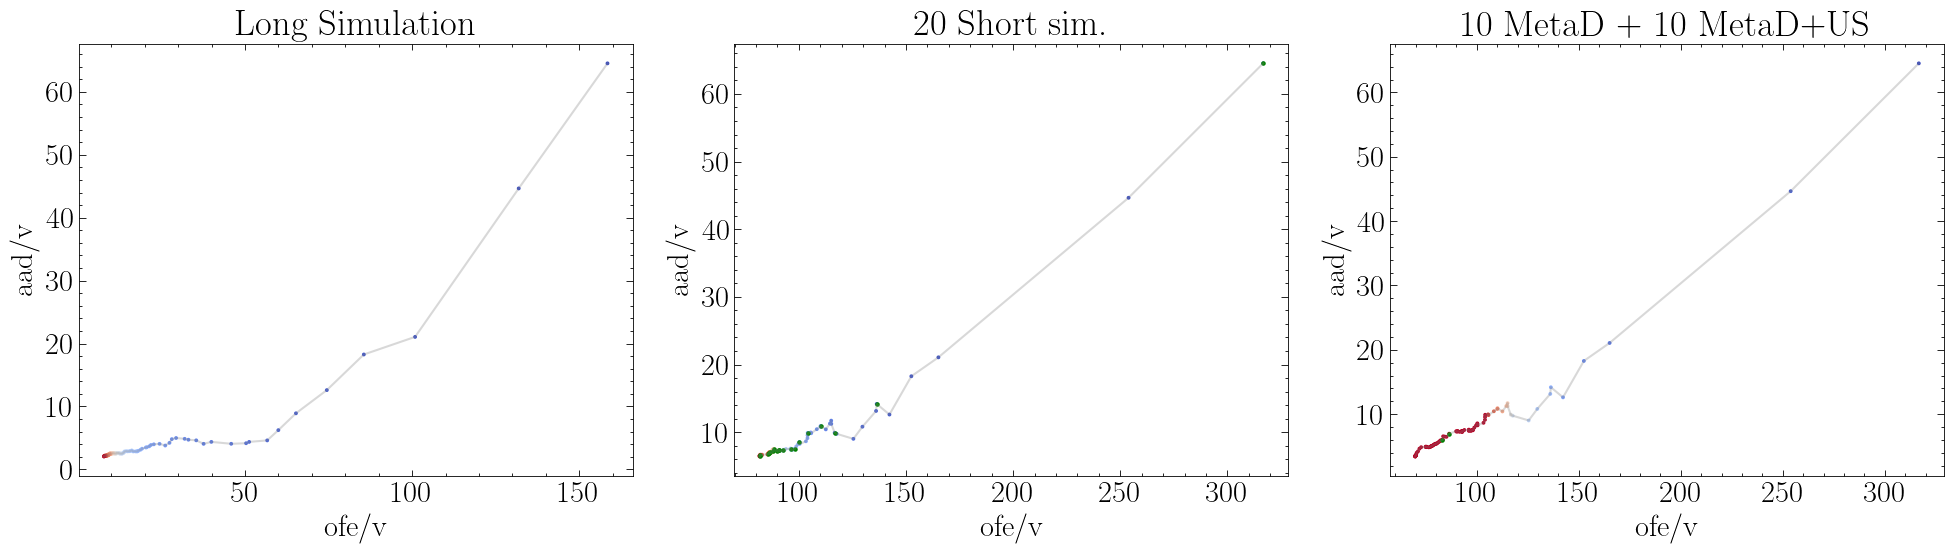

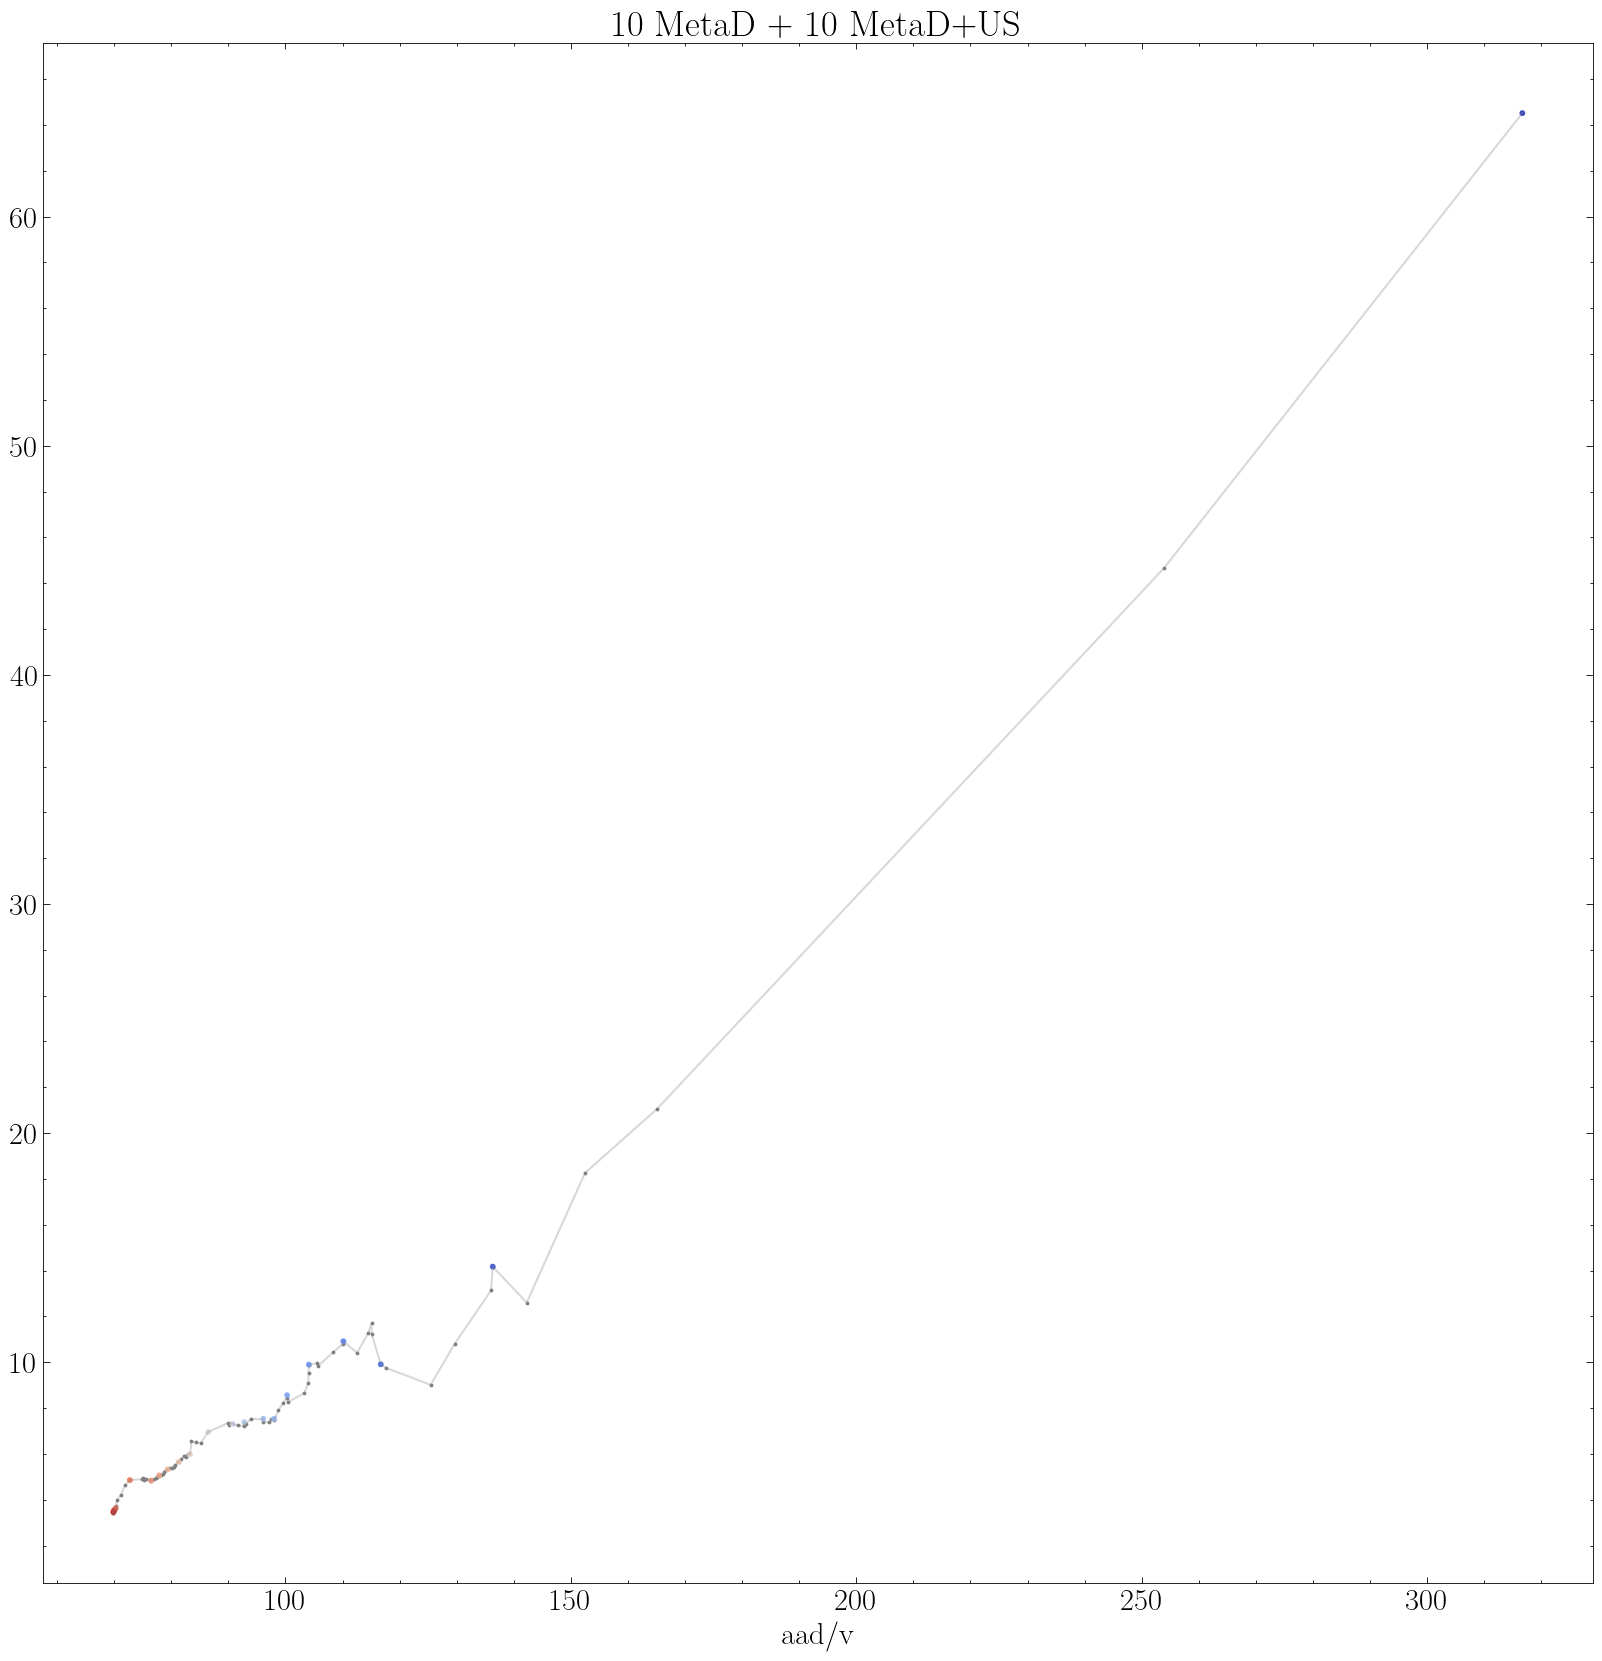

In [9]:
########## ->:62 Ftot_den_cutoff=0.1

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
plt.xlabel("ofe/v"); plt.ylabel("aad/v"); plt.title("Long Simulation")
# plt.ylim(0,6); plt.xlim(25,35)

plt.subplot(1,3,2)
plt.scatter(np.asarray(ofe_history_2)  / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1]  / np.asarray(volume_history_2) ,s=3, c=range(len(ofe_history_2)), cmap=cmap, norm=norm)
plt.scatter(np.asarray(ofe_history_2[::5])  / np.asarray(volume_history_2[::5]), np.asarray(aad_history_2)[:,1][::5]   / np.asarray(volume_history_2[::5]),s=5, c="green")
plt.plot(np.asarray(ofe_history_2)  / np.asarray(volume_history_2), np.asarray(aad_history_2)[:,1]  / np.asarray(volume_history_2), c="grey", alpha=0.3);
plt.xlabel("ofe/v"); plt.ylabel("aad/v"); plt.title("20 Short sim.")
# plt.ylim(0,6); plt.xlim(25,35)

norm = plt.Normalize(0, len(aad_history_3[::5]))
plt.subplot(1,3,3)
plt.scatter(np.asarray(ofe_history_3) / np.asarray(volume_history_3), np.asarray(aad_history_3)[:,1] / np.asarray(volume_history_3) ,s=3, c=range(len(ofe_history_3)), cmap=cmap, norm=norm)
plt.scatter(np.asarray(ofe_history_3[50]) / np.asarray(volume_history_3[50]), np.asarray(aad_history_3)[:,1][50] / np.asarray(volume_history_3[50]) ,s=5, c="green")
plt.scatter(np.asarray(ofe_history_3[55]) / np.asarray(volume_history_3[55]), np.asarray(aad_history_3)[:,1][55] / np.asarray(volume_history_3[55]) ,s=5, c="green")
plt.plot(np.asarray(ofe_history_3) / np.asarray(volume_history_3), np.asarray(aad_history_3)[:,1] / np.asarray(volume_history_3), c="grey", alpha=0.3); 
plt.xlabel("ofe/v"); plt.ylabel("aad/v"); plt.title("10 MetaD + 10 MetaD+US")
# plt.ylim(0,6); plt.xlim(25,35)
plt.tight_layout(); plt.show()

plt.figure(figsize=(20,20))
plt.scatter(np.asarray(ofe_history_3) / np.asarray(volume_history_3), np.asarray(aad_history_3)[:,1] / np.asarray(volume_history_3) ,s=3, c="grey")
plt.scatter(np.asarray(ofe_history_3[::5]) / np.asarray(volume_history_3[::5]), np.asarray(aad_history_3)[:,1][::5] / np.asarray(volume_history_3[::5]) ,s=10, c=range(len(ofe_history_3[::5])), cmap=cmap, norm=norm)
# plt.scatter(ofe_history_3[50], np.asarray(aad_history_3)[:,1][50] ,s=20, c="yellow")
# plt.scatter(ofe_history_3[-5], np.asarray(aad_history_3)[:,1][-5] ,s=20, c="yellow")
# plt.scatter(ofe_history_3[-1], np.asarray(aad_history_3)[:,1][-1] ,s=20, c="yellow")
plt.plot(np.asarray(ofe_history_3) / np.asarray(volume_history_3), np.asarray(aad_history_3)[:,1] / np.asarray(volume_history_3), c="grey", alpha=0.3); 
plt.xlabel("ofe/v"); plt.xlabel("aad/v"); plt.title("10 MetaD + 10 MetaD+US")
# plt.ylim(0,6); plt.xlim(25,35)
plt.show()

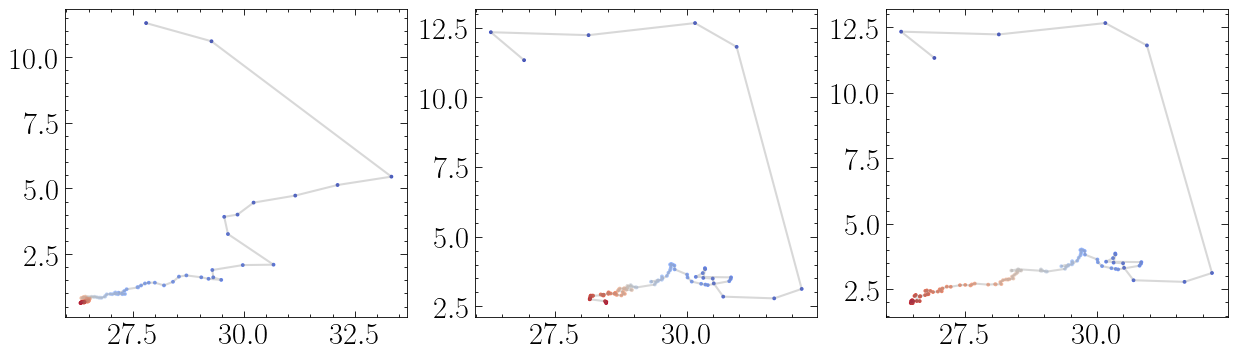

In [18]:
########## ->18: with  fes cut at inve_pot<19

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(ofe_history_1, np.asarray(aad_history_1)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_1, np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3)

plt.subplot(1,3,2)
plt.scatter(ofe_history_2, np.asarray(aad_history_2)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_2, np.asarray(aad_history_2)[:,1], c="grey", alpha=0.3)

plt.subplot(1,3,3)
plt.scatter(ofe_history_3, np.asarray(aad_history_3)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_3, np.asarray(aad_history_3)[:,1], c="grey", alpha=0.3)
plt.show()

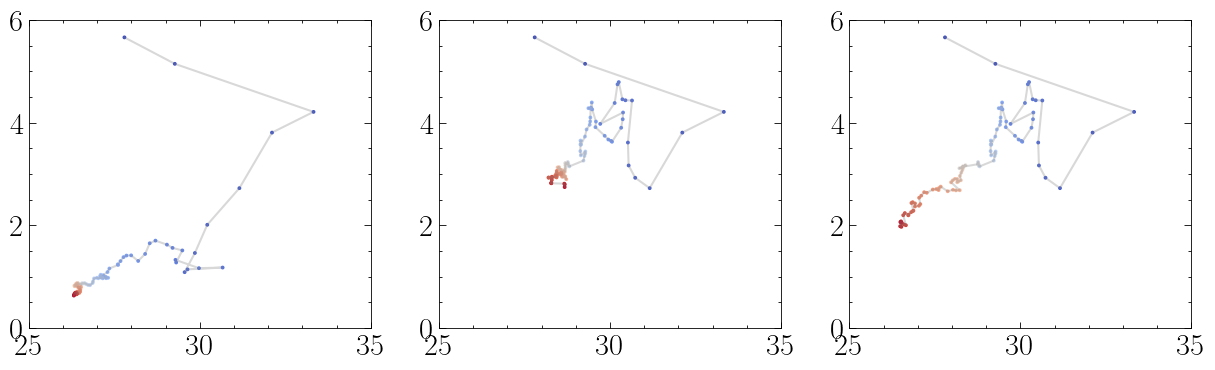

In [55]:
########## ->55: with  fes cut at inve_pot<19 and Ftot_den_cutoff=0.1

cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(ofe_history_1, np.asarray(aad_history_1)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_1, np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); plt.ylim(0,6); plt.xlim(25,35)

plt.subplot(1,3,2)
plt.scatter(ofe_history_2, np.asarray(aad_history_2)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_2, np.asarray(aad_history_2)[:,1], c="grey", alpha=0.3); plt.ylim(0,6); plt.xlim(25,35)

plt.subplot(1,3,3)
plt.scatter(ofe_history_3, np.asarray(aad_history_3)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_3, np.asarray(aad_history_3)[:,1], c="grey", alpha=0.3); plt.ylim(0,6); plt.xlim(25,35)

plt.show()

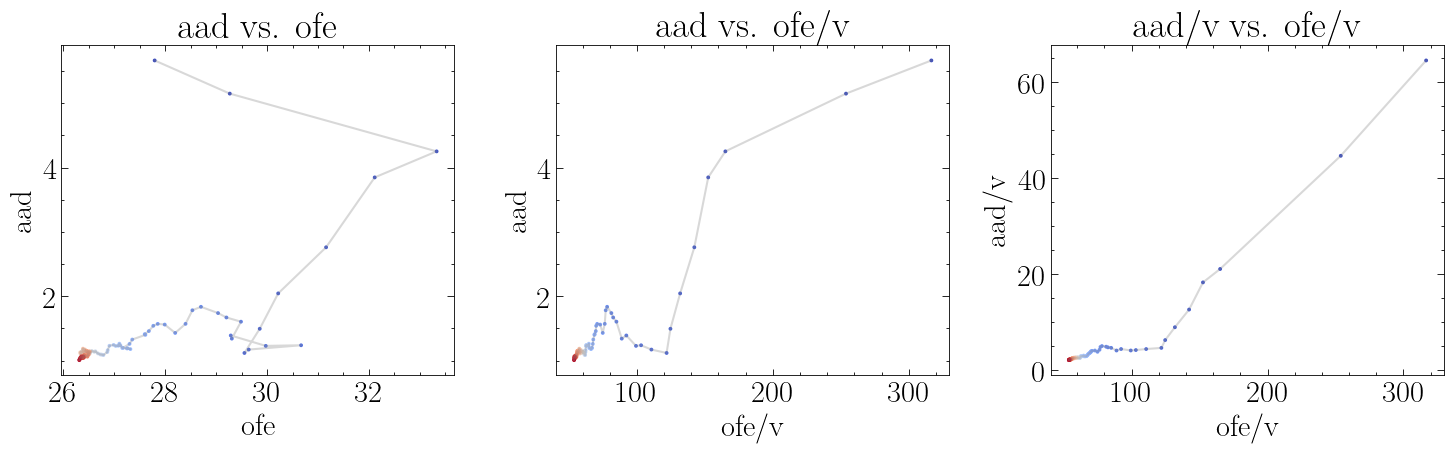

In [439]:
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(np.asarray(ofe_history_1) , np.asarray(aad_history_1)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) , np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); 
plt.title("aad vs. ofe"); plt.xlabel("ofe"); plt.ylabel("aad")

plt.subplot(1,3,2)
plt.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1]  ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); 
plt.title("aad vs. ofe/v"); plt.xlabel("ofe/v"); plt.ylabel("aad")

plt.subplot(1,3,3)
plt.scatter(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(np.asarray(ofe_history_1) / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) , c="grey", alpha=0.3); 
plt.title("aad/v vs. ofe/v"); plt.xlabel("ofe/v"); plt.ylabel("aad/v")
# plt.ylim(1.8,2.6); plt.xlim(50,60)
plt.tight_layout(); plt.show()


In [ ]:
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(ofe_history_1))

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(ofe_history_1, np.asarray(aad_history_1)[:,1] ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_1, np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); 
# plt.ylim(0,6); plt.xlim(25,35)

plt.subplot(1,3,2)
plt.scatter(ofe_history_1 / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_1, np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); 
# plt.ylim(0,6); plt.xlim(25,35)

plt.subplot(1,3,3)
plt.scatter(ofe_history_1 / np.asarray(volume_history_1), np.asarray(aad_history_1)[:,1] / np.asarray(volume_history_1) ,s=3, c=range(len(ofe_history_1)), cmap=cmap, norm=norm)
plt.plot(ofe_history_1, np.asarray(aad_history_1)[:,1] , c="grey", alpha=0.3); 
# plt.ylim(0,6); plt.xlim(25,35)

plt.show()

### INV POT

In [24]:
def make_external_bias_2D(X,Y, FES, Ftot_x, Ftot_y, FES_lim, grid_min_plumed=None, grid_max_plumed=None, nbins_plumed=None, file_name_extension=""):
    
    #if grid_min_plumed or grid_max_plumed not defined, estimate it
    if grid_min_plumed == None:
        grid_min_plumed = [X[0][0] - 2, Y[0][0] - 2]
    if grid_max_plumed == None:
        grid_max_plumed = [X[-1][-1] + 2, Y[-1][-1] + 2]
    if nbins_plumed == None:
        nbins_plumed = [np.shape(X)[1], np.shape(X)[0]]     
    
    #create new grid for plumed
    grid_x = np.linspace(grid_min_plumed[0], grid_max_plumed[0], nbins_plumed[0]); 
    grid_y = np.linspace(grid_min_plumed[1], grid_max_plumed[1], nbins_plumed[1]); 
    XX, YY = np.meshgrid(grid_x, grid_y)

    #interpolate FES and Ftot on new grid
    grid_mfi_x = np.linspace(X[0][0], X[-1][-1], np.shape(X)[1])
    grid_mfi_y = np.linspace(Y[0][0], Y[-1][-1], np.shape(X)[0])
    
    FES = np.where(FES < FES_lim, FES, FES_lim)
    FES = - FES - np.min(-FES)
    FES_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, FES, kind='cubic')
    Ftot_x_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, Ftot_x, kind='cubic')
    Ftot_y_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, Ftot_y, kind='cubic')
    
    FES_plumed = FES_interpolate(grid_x, grid_y)
    FES_plumed = FES_plumed - np.min(FES_plumed)
    Ftot_x_plumed = Ftot_x_interpolate(grid_x, grid_y)
    Ftot_y_plumed = Ftot_y_interpolate(grid_x, grid_y)
    
    # FES_plumed_2 = np.where(FES_plumed < FES_lim, FES_plumed, FES_lim)
    # FES_plumed_2 = -FES_plumed_2 - np.min(-FES_plumed_2)
    Ftot_y_plumed_2, Ftot_x_plumed_2 = np.gradient(FES_plumed)

    XX_flat = XX.flatten()
    YY_flat = YY.flatten()
    FES_plumed_flat = FES_plumed.flatten()
    Ftot_x_plumed_2_flat = Ftot_x_plumed_2.flatten()
    Ftot_y_plumed_2_flat = Ftot_y_plumed_2.flatten()
    
    external_bias_vector = np.array([XX_flat, YY_flat, FES_plumed_flat, Ftot_x_plumed_2_flat, Ftot_y_plumed_2_flat]).T       


    with open("external_bias2.dat", "w") as f:
        f.write("#! FIELDS p.x p.y external.bias der_p.x der_p.y\n")
        f.write("#! SET min_p.x " + str(XX[0][0]) + "\n")
        f.write("#! SET max_p.x " + str(XX[-1][-1]) + "\n")
        f.write("#! SET nbins_p.x " + str(len(grid_x)) + "\n")
        f.write("#! SET periodic_p.x false\n")
        f.write("#! SET min_p.y " + str(YY[0][0]) + "\n")
        f.write("#! SET max_p.y " + str(YY[-1][-1]) + "\n")
        f.write("#! SET nbins_p.y " + str(len(grid_y)) + "\n")
        f.write("#! SET periodic_p.y false\n")
        for i in range(0, len(external_bias_vector), len(grid_x)):
            np.savetxt(f, external_bias_vector[i:i+len(grid_x)], fmt='%f')
            f.write("\n")

    Ftot_x_return_interpolate = interpolate.interp2d(grid_x, grid_y, Ftot_x_plumed, kind='cubic')
    Ftot_y_return_interpolate = interpolate.interp2d(grid_x, grid_y, Ftot_y_plumed, kind='cubic')
    
    Ftot_x_return = Ftot_x_return_interpolate(grid_mfi_x, grid_mfi_y)
    Ftot_y_return = Ftot_y_return_interpolate(grid_mfi_x, grid_mfi_y)
    
    for __plot__ in [1]:
        plt.figure(1,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(X,Y,FES)#, levels= np.linspace(0,30,30))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(X,Y,Ftot_x, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(X,Y,Ftot_y, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        # plt.show()

        plt.figure(2,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(XX,YY,FES_plumed, levels= np.linspace(0,30,30))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(XX,YY,Ftot_x_plumed, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(XX,YY,Ftot_y_plumed, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        # plt.show()
        
        XXX, YYY, FFFES = MFI.FFT_intg_2D(FX=Ftot_x_plumed, FY=Ftot_y_plumed, min_grid=grid_min_plumed, max_grid=grid_max_plumed)
        FFFES = -FFFES - np.min(-FFFES)

        plt.figure(3,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(X,Y,FES, levels= np.linspace(0,30,30))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(X,Y,Ftot_x_return, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(X,Y,Ftot_y_return, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        # plt.show()
    


    return [Ftot_x_return, Ftot_y_return]


In [34]:
def make_external_bias_2D(X,Y, FES, Ftot_x, Ftot_y, FES_lim, x_padding=[0,0], y_padding=[0,0], file_name_extension=""):
    
    # MFI grid
    grid_mfi_x = np.linspace(X[0][0], X[-1][-1], np.shape(X)[1])
    grid_mfi_y = np.linspace(Y[0][0], Y[-1][-1], np.shape(X)[0])
    dx_mfi, dy_mfi = grid_mfi_x[1]-grid_mfi_x[0] , grid_mfi_y[1]-grid_mfi_y[0] 
    
    
    #create new grid for plumed
    grid_min_plumed , grid_max_plumed = [0,0], [0,0]
    if x_padding[0] <= 0: x_padding[0] = int((grid_mfi_x[-1] - grid_mfi_x[0])/(4*dx_mfi)) * dx_mfi
    grid_min_plumed[0] = grid_mfi_x[0] - int(x_padding[0]/dx_mfi) * dx_mfi
    if x_padding[1] <= 0: x_padding[1] = int((grid_mfi_x[-1] - grid_mfi_x[0])/(4*dx_mfi)) * dx_mfi
    grid_max_plumed[0] = grid_mfi_x[-1] + int(x_padding[1]/dx_mfi) * dx_mfi

    x_pad_bins = [int(x_padding[0]/dx_mfi) , -int(x_padding[1]/dx_mfi)]
    
    if y_padding[0] <= 0: y_padding[0] = int((grid_mfi_y[-1] - grid_mfi_y[0])/(4*dy_mfi)) * dy_mfi
    grid_min_plumed[1] = grid_mfi_y[0] - int(y_padding[0]/dy_mfi) * dy_mfi
    if y_padding[1] <= 0: y_padding[1] = int((grid_mfi_y[-1] - grid_mfi_y[0])/(4*dy_mfi)) * dy_mfi
    grid_max_plumed[1] = grid_mfi_y[-1] + int(y_padding[1]/dy_mfi) * dy_mfi
    
    y_pad_bins = [int(y_padding[0]/dy_mfi) , -int(y_padding[1]/dy_mfi)]

    nbins_plumed = [int(round((grid_max_plumed[0] - grid_min_plumed[0])/dx_mfi,5))+1, int(round((grid_max_plumed[1] - grid_min_plumed[1])/dy_mfi,5))+1]
    
    grid_plumed_x = np.linspace(grid_min_plumed[0], grid_max_plumed[0], nbins_plumed[0]); 
    grid_plumed_y = np.linspace(grid_min_plumed[1], grid_max_plumed[1], nbins_plumed[1]); 
    dx_plumed, dy_plumed = dx_mfi, dy_mfi
    XX, YY = np.meshgrid(grid_plumed_x, grid_plumed_y)

    FES = np.where(FES < FES_lim, FES, FES_lim)
    FES = - FES - np.min(-FES)
    
    FES_plumed = np.zeros_like(XX)
    FES_plumed[y_pad_bins[0]:y_pad_bins[1], x_pad_bins[0]:x_pad_bins[1]] = FES
    
    Ftot_y_plumed_2, Ftot_x_plumed_2 = np.gradient(FES_plumed, grid_plumed_y, grid_plumed_x)

    XX_flat = XX.flatten()
    YY_flat = YY.flatten()
    FES_plumed_flat = FES_plumed.flatten()
    Ftot_x_plumed_2_flat = Ftot_x_plumed_2.flatten()
    Ftot_y_plumed_2_flat = Ftot_y_plumed_2.flatten()

    external_bias_vector = np.array([XX_flat, YY_flat, FES_plumed_flat, Ftot_x_plumed_2_flat, Ftot_y_plumed_2_flat]).T       

    with open("external_bias2.dat", "w") as f:
        f.write("#! FIELDS p.x p.y external.bias der_p.x der_p.y\n")
        f.write("#! SET min_p.x " + str(XX[0][0]) + "\n")
        f.write("#! SET max_p.x " + str(XX[-1][-1]) + "\n")
        f.write("#! SET nbins_p.x " + str(nbins_plumed[0]) + "\n")
        f.write("#! SET periodic_p.x false\n")
        f.write("#! SET min_p.y " + str(YY[0][0]) + "\n")
        f.write("#! SET max_p.y " + str(YY[-1][-1]) + "\n")
        f.write("#! SET nbins_p.y " + str(nbins_plumed[1]) + "\n")
        f.write("#! SET periodic_p.y false\n")
        for i in range(0, len(external_bias_vector), len(XX)):
            np.savetxt(f, external_bias_vector[i:i+len(XX)], fmt='%f')
            f.write("\n")



    return [-Ftot_x_plumed_2[y_pad_bins[0]:y_pad_bins[1], x_pad_bins[0]:x_pad_bins[1]], -Ftot_y_plumed_2[y_pad_bins[0]:y_pad_bins[1], x_pad_bins[0]:x_pad_bins[1]]]


In [36]:
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_INV_BIAS")
pbt_bandwidth = 0.05
n_simulations = 20

###################################  RUN 1st simulation ###################################

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_0")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_0")

#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = 0.05, bw_y = 0.05, kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), error_pace = 100, FES_cutoff=-1, nhills=-1, ref_fes=inve_pot, use_weighted_st_dev = False)


master = [[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_x]]
master_patch = [[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_x]]
ofe_history_patch = ofe_history
aad_history_patch = aad_history
volume_history_patch = volume_history
ofe_history_patch_time = time_history

###################################  RUN other simulations simulation ###################################


for simulation in np.arange(1,n_simulations): 
    
    [_, _, FES_patch] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))
    
    [F_ext_x, F_ext_y] = make_external_bias_2D(X,Y, FES_patch, master_patch[-1][2], master_patch[-1][3], FES_lim=20)

    initial_pos = [round(np.random.uniform(-3, 3), 3) , round(np.random.uniform(-3, 3), 3)]
    file_extension="INVBIAS_" + str(int(simulation))
    run_plumed.run_2D_Invernizzi(simulation_steps=250000, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=initial_pos[0], initial_position_y=initial_pos[1], file_extension=file_extension, external_bias_file="external_bias2.dat")
    # print('\nSimulation: ' + str(simulation) + ' (ext=' + str(file_extension) + ')' )

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_" + file_extension)
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_" + file_extension)

    #COMPUTE Mean force and weight of the simulation
    results = MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw_x = pbt_bandwidth, bw_y = pbt_bandwidth, kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), error_pace=100, base_terms = master_patch[-1], ref_fes=inve_pot, F_static_x=-F_ext_x, F_static_y=-F_ext_y, use_weighted_st_dev = False)
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history
    ofe_history_patch += ofe_history
    aad_history_patch += aad_history
    volume_history_patch += volume_history
    if len(ofe_history_patch_time) > 0: ofe_history_patch_time += [element+ofe_history_patch_time[-1] for element in time_history]
    else: ofe_history_patch_time += time_history



    #integration on a non-periodic! domain
    [Xp, Yp, FES_patch] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))
    cutoff_2 = MFI.get_cutoff(Ftot_den=master_patch[-1][0])

    AD = abs(inve_pot - FES_patch) 
    ADc = AD * cutoff_2
    # ADc = np.where(inve_pot < 19, ADc, 0)
    AAD = np.sum(AD)/(FES_patch.shape[0]*FES_patch.shape[0])
    AADc = np.sum(ADc)/(np.count_nonzero(ADc))
    print("\nAAD:", AAD)
    print("AAD cut:", AADc)

[FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2, volume_history_2] = [FES_patch, master_patch[-1][0], ofe, ADc, cutoff_2, ofe_history_patch_time, ofe_history_patch, aad_history_patch, volume_history_patch]

|**************************************************| 100% | Average Mean Force Error: 16.313Running simulation...
|**************************************************| 100% | Average Mean Force Error: 15.052
AAD: 35.54195441167407

AAD cut: 2.0752693052870455 

Running simulation...
|**************************************************| 100% | Average Mean Force Error: 7.878
AAD: 34.55738528384229

AAD cut: 1.75808222428677 

Running simulation...
|**************************************************| 100% | Average Mean Force Error: 6.69
AAD: 34.221345785602175

AAD cut: 1.6324034978407125 

Running simulation...
|**************************************************| 100% | Average Mean Force Error: 5.766
AAD: 34.155436165273315

AAD cut: 1.6662141447335728 

Running simulation...
|**************************************************| 100% | Average Mean Force Error: 5.361
AAD: 34.44523127981711

AAD cut: 1.9489010946468872 

Running simulation...
|*********************************************

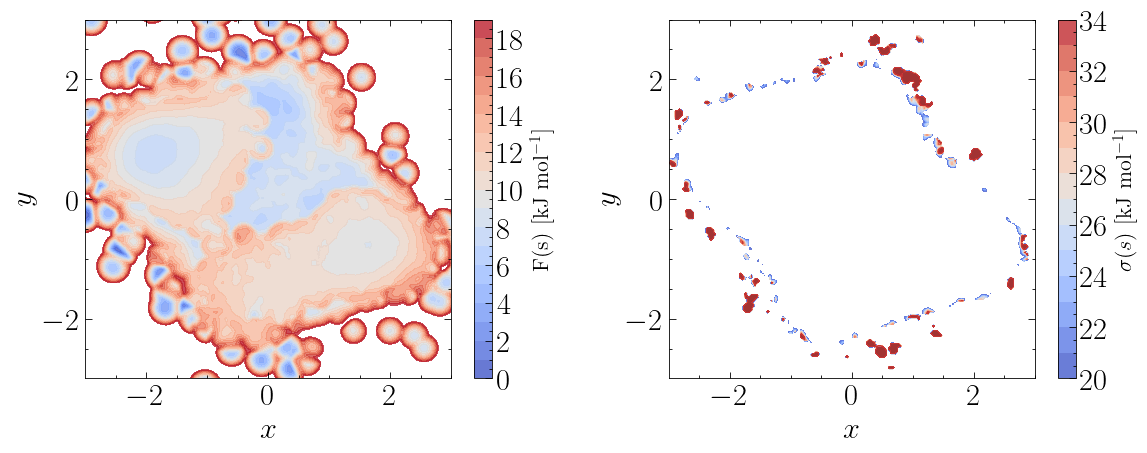

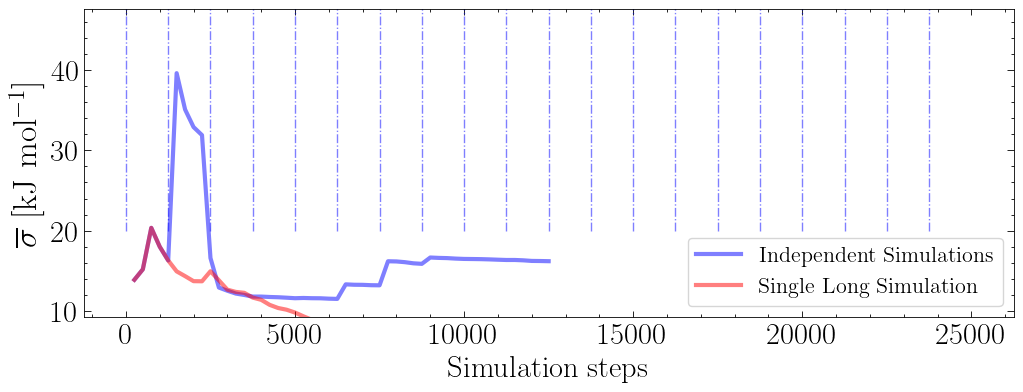

In [35]:
# plot 2
os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data")

#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i] for i in range(n_simulations)]

# Plot Results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cp = axs[0].contourf(Xp, Yp, FES_patch, levels=np.arange(0, 20, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, ofe_2*cutoff_2, levels=[35,200], cmap=colors.ListedColormap(['darkred']), antialiased=False, alpha=0.8);
cp = axs[1].contourf(X, Y, ofe_2*cutoff_2, levels=np.arange(20, 35, 1), cmap='coolwarm', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$]",fontsize=16)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()    

plt.savefig('Figure2_C', dpi=600, bbox_inches='tight')

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in ofe_history_patch_time], (ofe_history_patch),color='blue',alpha=0.5,linewidth=3,label="Independent Simulations");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')
axs.tick_params(axis ='y', labelcolor = 'black')

axs.plot( time_history_1, ofe_history_1 ,color='red',alpha=0.5,linewidth=3,label="Single Long Simulation");
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$]',fontsize=24, color='black')

axs.set_xlabel('Simulation steps')

for i in np.arange(0,n_simulations):
    axs.plot([i*1250,i*1250],[20,50],'-.',color='blue',linewidth=1,alpha=0.5)

axs.set_ylim([min(ofe_history_patch)*0.8,max(ofe_history_patch)*1.2])

axs.legend(fontsize=16)

# plt.savefig('Figure2_D', dpi=600, bbox_inches='tight')

#ax2 = axs.twinx()
#ax2.set_xlabel('Simulation steps')
#ax2.set_ylabel('Sampled Volume',color='red')
#ax2.tick_params(axis ='y', labelcolor = 'red')
#ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:],np.power(6/200,2)),color='red',alpha=0.5,linewidth=3);
